In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import scipy.stats as stats
from findpeaks import findpeaks
from electrodes_manipulation import Eletrode
import os

In [3]:
elec = Eletrode()

In [4]:
operational_system = os.name
print(f"Operational System: {operational_system}")

Operational System: posix


Reading all data from the electrodes datasets 

In [5]:
path_cometial_rodamine = ''
path_comertial_virgin = ''
path_polimide_rodamine = ''
path_polimide_virgin = ''

if operational_system == 'posix':
    path_cometial_rodamine = '/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/data/comercial_rodamina.csv'
    path_comertial_virgin = '/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/data/comercial.csv'
    path_polimide_rodamine = '/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/data/polimida_rodamina.csv'
    path_polimide_virgin = '/home/pedro/Documentos/WorkspaceProjetos/Heart_Attack/data/Polimida.csv'
else:
    path_cometial_rodamine = 'C:\\Users\\pves\\Documents\\Voxar_Contexto\Workspace\\heart_attack_analysis\\data\\comercial_rodamina.csv'
    path_comertial_virgin = 'C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\data\\comercial.csv'
    path_polimide_rodamine = 'C:\\Users\\pves\\Documents\\Voxar_Contexto\\Workspace\\heart_attack_analysis\\data\\polimida_rodamina.csv'
    path_polimide_virgin = 'C:\\Users\\pves\\Documents\\Voxar_Contexto\Workspace\\heart_attack_analysis\\data\\Polimida.csv'
    
comertial_electrode = pd.read_csv(path_comertial_virgin, sep=';')
comertial_rodamine = pd.read_csv(path_cometial_rodamine, sep=';')
polimid_df = pd.read_csv(path_polimide_virgin, sep=';')
polimid_rodamine_df = pd.read_csv(path_polimide_rodamine, sep=';')

In [6]:
comertial_electrode.head()

,V,A1,A2,A3
0,"0,649998","59,9268","56,3561","56,2829"
1,"0,648002","59,5514","55,9991","55,935"
2,"0,646005","59,1852","55,6695","55,6054"
3,"0,644009","58,8464","55,3491","55,285"
4,"0,642012","58,4985","55,0378","54,9737"


In [7]:
comertial_rodamine.head()

,V,Ac1 ac+R6G VC,Ac2 ac+R6G VC,Ac3 ac+R6G VC,Ac4 ac+R6G VC
0,"0,649998","59,1577","60,1831","59,6979","61,236"
1,"0,648002","57,8759","58,9563","58,352","59,9268"
2,"0,646005","57,2625","58,3429","57,7111","59,2859"
3,"0,644009","56,7773","57,8485","57,2168","58,7823"
4,"0,642012","56,3287","57,3999","56,759","58,3062"


In [8]:
polimid_df.head()

,V,B5 13071,C2 13071,D6 13071,E3 13071
0,"0,550022","49,0867","48,986","51,9066","48,51"
1,"0,548026","45,6168","45,388","48,4001","44,7837"
2,"0,546029","44,2252","43,9048","46,862","43,2639"
3,"0,544033","43,3555","43,035","45,9464","42,3667"
4,"0,542036","42,6871","42,3575","45,2689","41,6983"


In [9]:
polimid_rodamine_df.head()

,V,A4 ac+rod becker 30s,C3 ac+rod becker 30s,D2 ac+rod becker 30s,E5 ac+rod becker 30s
0,"0,550022","42,6413","44,4907","43,3371","43,6301"
1,"0,548026","41,7258","43,447","42,1836","42,7695"
2,"0,546029","41,2589","42,9252","41,6983","42,211"
3,"0,544033","40,8194","42,5132","41,2039","41,7624"
4,"0,542036","40,5447","42,1286","40,7828","41,4328"


# Convertendo todos os valores para float

In [10]:
comertial_electrode = elec.convert_df_to_float_df(comertial_electrode)
comertial_rodamine = elec.convert_df_to_float_df(comertial_rodamine)
polimid_df = elec.convert_df_to_float_df(polimid_df)
polimid_rodamine_df = elec.convert_df_to_float_df(polimid_rodamine_df)

Verificando a existência de valores nulos ou que não são números

In [11]:
print(comertial_electrode.isna().any().sum())
print(comertial_rodamine.isna().any().sum())
print(polimid_df.isna().any().sum())
print(polimid_rodamine_df.isna().any().sum())

0
0
0
0


In [12]:
# Função que retorma o vetor do tempo dado o vetor de potencial e o scan_rate
def getTime( scan_rate, potential ):
    time = np.zeros(shape=potential.shape)
    delta_t = abs(potential[1] - potential[0]) / scan_rate
    
    for i in range(1, len(potential)):
        time[i] = delta_t + time[i - 1]
    
    return time
    
# Função que retorna o tempo total da série de voltametria cíclica
def get_total_time( scan_rate, potential):
    time = getTime(scan_rate, potential)
    return time[len(time)-1] 
    
# Função de Filtragem do sinal
def filter_low_pass_butterworth( fs, fc, order, y):
    # Frequência de corte normalizada
    w = fc / (fs / 2)
    print(f"Critical frequency {w}")
    b, a = signal.butter(order, w, 'low')
    out = signal.lfilter(b, a, y)
    #print(f'Shape Saida: {len(out)}')
    return out
    
# Função que calcula o sample rate do processo
def get_sampleRate( totalTime, lenght):
    return lenght / totalTime
    

    
# Função que calcula a primeira derivada
def derivate(x_axis, y_axis, time = False):
    
        #print(f'X Shape {len(x_axis)}')
        #print(f'Y Shape {len(y_axis)}')
    sample_rate = 0
    h = abs(x_axis[1] - x_axis[0])          # Calculating h difference
    # Padding to not losing data between derivate
    y = np.zeros(shape = (len(y_axis) + 2))
    # Coping the y array into y
    y[1:-1] = y_axis
    # Duplicating the last and the first elements
    y[0] = y_axis[0]
    y[len(y) - 1] = y_axis[len(y_axis) - 1]
    
    for k in range(len(y) - 1):
        y[k] = (y[k + 1] - y[k])/h
    
    # Filtragem do sinal da derivada
    if (not(time)):
        total_time = get_total_time(0.75, x_axis)
        sample_rate = get_sampleRate(total_time, len(x_axis))
    else:
        sample_rate = 1 / h
        
    out = filter_low_pass_butterworth(sample_rate, 5, 10, y[1:-1])
    #print(len(out))
    return (y[1:-1], out)

# Pega os argomentos das correntes anódicas e catódicas, retorna -1 se não achar o pico
def getAnodicAndCathodicArguments(current, fp, ox_inf = 500, ox_sup = 630, red_inf = 200, red_sup = 300):
    result_an_arg = 0
    result_cat_arg = 0
    # Encontrando os picos das duas funções
    results = fp.fit(current)
    #fp.plot(figsize=(12,7))
    results_df = results['df']
    # Separando os picos relacionados à oxidação
    results_oxidation = results_df.iloc[ox_inf:ox_sup,:]
    results_reduction = results_df.iloc[red_inf:red_sup, :]
    arg_anodic = results_oxidation[results_oxidation['peak'] == True]['x'].values
    arg_cathodic = results_reduction[results_reduction['valley'] == True]['x'].values
    
    if (len(arg_anodic) == 0):
        print("Erro na corrente anódica")
        result_an_arg = -1
    else:
        result_an_arg = arg_anodic[0]
        
    if (len(arg_cathodic) == 0):
        print("Erro na corrente catódica")
        result_cat_arg = -1
    else:
        result_cat_arg = arg_cathodic[0]
        
    return (result_an_arg, result_cat_arg)

# Calcula a carga total
def getTotalCharge(current, time):
    charge = np.trapz(current, time, axis=0)
    return charge

## Montando o dataset para o eletrodo comercial
Neste passo as observações são com relação ao potencial

Critical frequency 0.026588059512503717
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026588059512503717
Critical frequency 0.026588059512503717
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


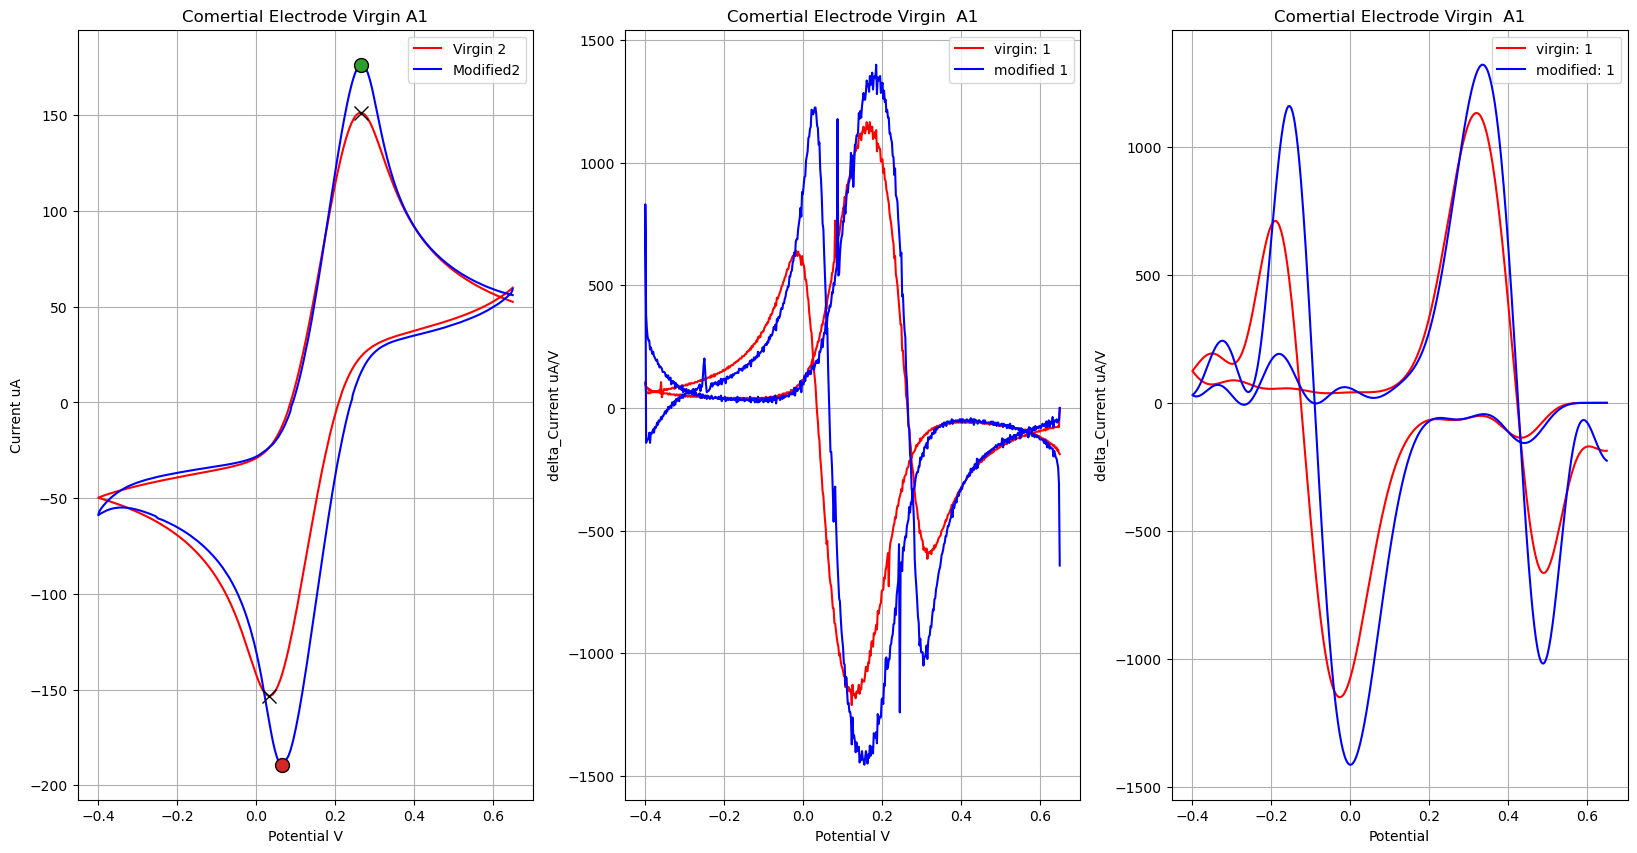

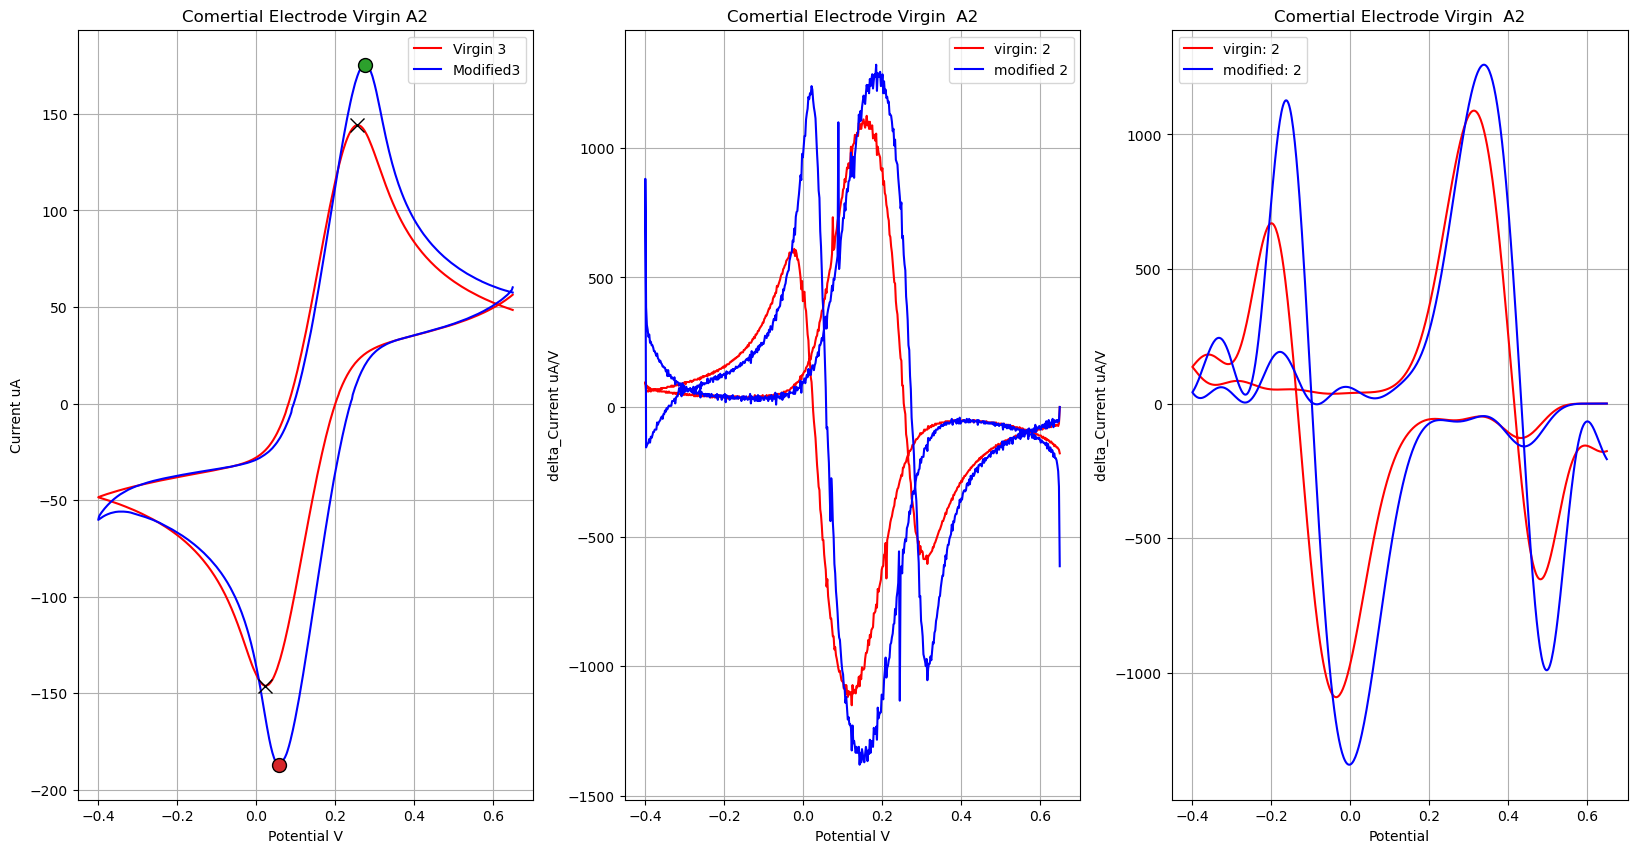

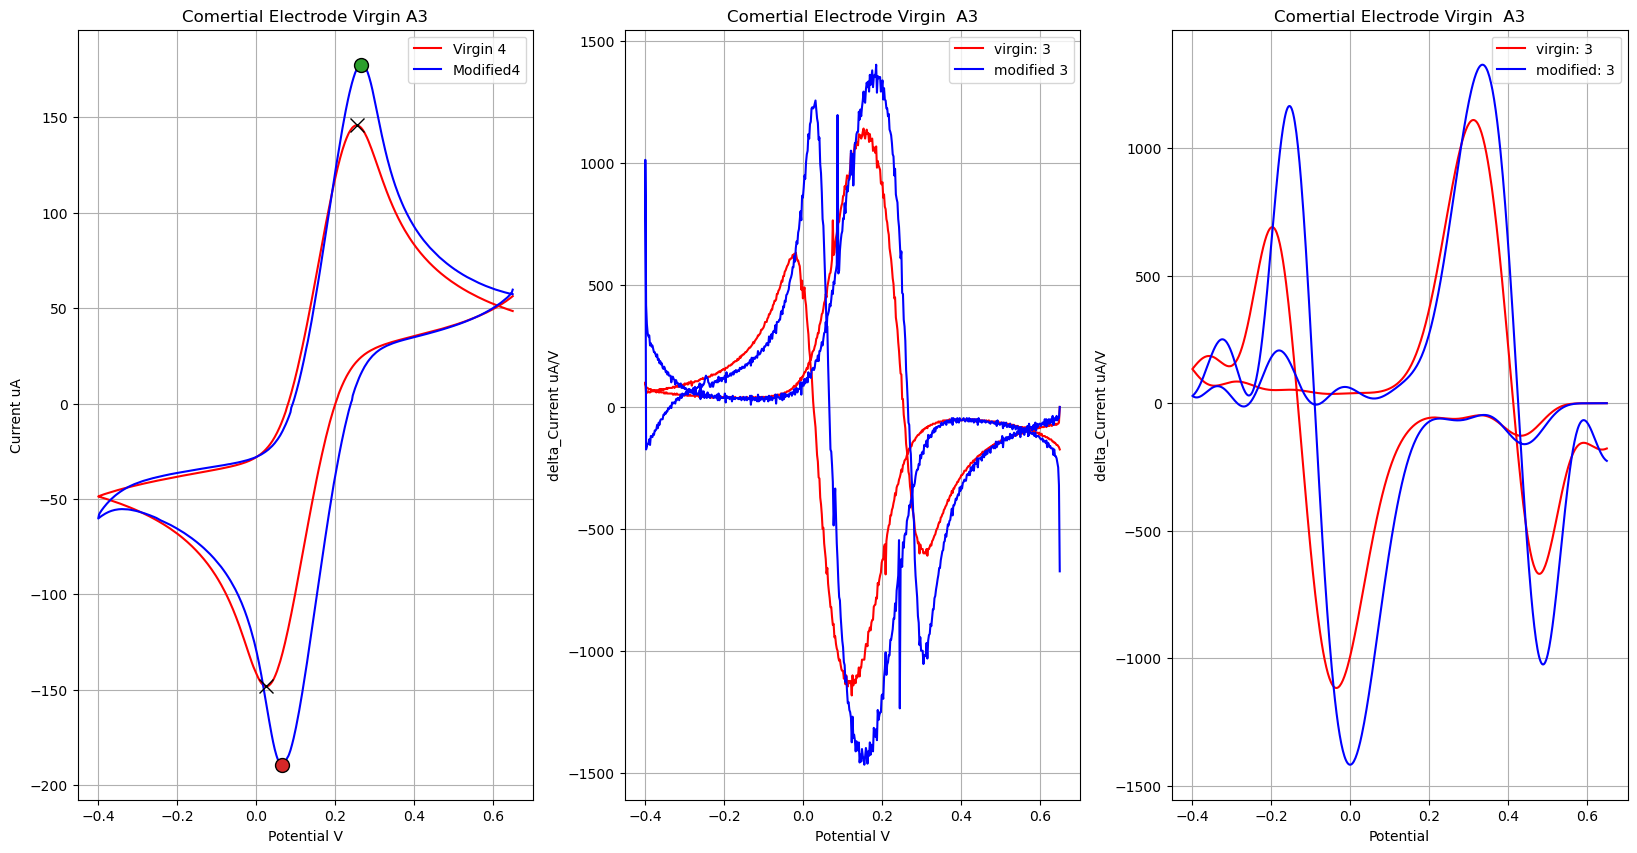

In [13]:
# Dados de eletrodos comerciais sem rodamina
comertial_elec_derivate = pd.DataFrame(columns=comertial_electrode.columns)
comertial_elec_anodic_current = []
comertial_elec_cathodic_current = []
comertial_elec_diff_ano_cat_potential = []
comertial_elec_diff_ano_cat_current = []
potential_comertial_elec = comertial_electrode.loc[:, comertial_electrode.columns[0]].values
comertial_elec_derivate[comertial_electrode.columns[0]] = potential_comertial_elec

# Dados de eletrodos comerciais com rodamina
comertial_elec_derivate_rod = pd.DataFrame(columns=comertial_rodamine.columns)
comertial_elec_anodic_current_rod = []
comertial_elec_cathodic_current_rod = []
comertial_elec_diff_ano_cat_potential_rod = []
comertial_elec_diff_ano_cat_current_rod = []
potential_comertial_elec_rod = comertial_rodamine.loc[:, comertial_rodamine.columns[0]].values
comertial_elec_derivate_rod[comertial_rodamine.columns[0]] = potential_comertial_elec_rod

fp = findpeaks(method='peakdetect', lookahead=10)

plot_peak = True

for i in range (1, comertial_electrode.shape[1]):
    
    current = comertial_electrode.iloc[:, i].values
    current_rod = comertial_rodamine.iloc[:, i].values

    current_derivate, derived_current_filtered = derivate(potential_comertial_elec, current)
    current_derivate_rod, derived_current_filtered_rod = derivate(potential_comertial_elec, current_rod)

    comertial_elec_derivate[comertial_electrode.columns[i]] = derived_current_filtered
    comertial_elec_derivate_rod[comertial_rodamine.columns[i]] = derived_current_filtered_rod

    (anodic, cathodic) = getAnodicAndCathodicArguments(current, fp, ox_inf = 800, ox_sup = 900, red_inf = 200, red_sup = 400)
    (anodic_rod, cathodic_rod) = getAnodicAndCathodicArguments(current_rod, fp, ox_inf = 780, ox_sup = 900, red_inf = 200, red_sup = 350)
    
    if (anodic_rod != -1 and cathodic_rod != -1):
        comertial_elec_anodic_current_rod.append(current_rod[anodic_rod])
        comertial_elec_cathodic_current_rod.append(current_rod[cathodic_rod])
        comertial_elec_diff_ano_cat_current_rod.append(abs(current_rod[anodic_rod] - current_rod[cathodic_rod]))
        comertial_elec_diff_ano_cat_potential_rod.append(abs(potential_comertial_elec[anodic_rod] - potential_comertial_elec[cathodic_rod]))
        
    elif (anodic_rod == -1):
         comertial_elec_anodic_current_rod.append(np.nan)
         comertial_elec_cathodic_current_rod.append(np.nan)
         comertial_elec_diff_ano_cat_current_rod.append(np.nan)
         comertial_elec_diff_ano_cat_potential_rod.append(current_rod[cathodic_rod])
         
    elif (cathodic_rod == -1):
        comertial_elec_anodic_current_rod.append(current_rod[anodic_rod])
        comertial_elec_cathodic_current_rod.append(np.nan)
        comertial_elec_diff_ano_cat_current_rod.append(np.nan)
        comertial_elec_diff_ano_cat_potential_rod.append(np.nan)
    
    
    if (anodic != -1 and cathodic != -1):
        comertial_elec_anodic_current.append(current[anodic])
        comertial_elec_cathodic_current.append(current[cathodic])
        comertial_elec_diff_ano_cat_current.append(abs(current[anodic] - current[cathodic]))
        comertial_elec_diff_ano_cat_potential.append(abs(potential_comertial_elec[anodic] - potential_comertial_elec[cathodic]))
        plot_peak = True
        
    elif (anodic == -1):
         comertial_elec_anodic_current.append(np.nan)
         comertial_elec_cathodic_current.append(np.nan)
         comertial_elec_diff_ano_cat_current.append(np.nan)
         comertial_elec_diff_ano_cat_potential.append(current[cathodic])
         
    elif (cathodic == -1):
        comertial_elec_anodic_current.append(current[anodic])
        comertial_elec_cathodic_current.append(np.nan)
        comertial_elec_diff_ano_cat_current.append(np.nan)
        comertial_elec_diff_ano_cat_potential.append(np.nan)

 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
    ax1.set_title("Comertial Electrode Virgin " + comertial_electrode.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Potential V")
    ax1.grid(True)
        
    ax2.set_title("Comertial Electrode Virgin  " + comertial_electrode.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Potential V")
        
    ax2.grid(True)
        
    ax3.set_title("Comertial Electrode Virgin  " + comertial_electrode.columns[i])
    ax3.set_ylabel("delta_Current uA/V")
    ax3.set_xlabel("Potential")
        
    ax3.grid(True)
        
          
    ax1.plot(potential_comertial_elec, current, color='r', label="Virgin " + str(i + 1))
    ax1.plot(potential_comertial_elec, current_rod, color='b', label="Modified" + str(i + 1))

    if (plot_peak):
        ax1.plot(potential_comertial_elec[anodic], current[anodic], marker="x", markersize=10, markeredgecolor="black")
        ax1.plot(potential_comertial_elec[cathodic], current[cathodic], marker="x", markersize=10, markeredgecolor="black")

        ax1.plot(potential_comertial_elec[anodic_rod], current_rod[anodic_rod], marker="o", markersize=10, markeredgecolor="black")
        ax1.plot(potential_comertial_elec[cathodic_rod], current_rod[cathodic_rod], marker="o", markersize=10, markeredgecolor="black")
        
    ax1.legend() 
    ax2.plot(potential_comertial_elec, current_derivate, color='r', label="virgin: " + str(i))
    ax2.plot(potential_comertial_elec, current_derivate_rod, color='b', label="modified " + str(i))
    ax2.legend()
    #ax3.plot(potential_neg, derived_current_filtered, color=colors[plots], label="case: " + str(plots + 1))
    ax3.plot(potential_comertial_elec, derived_current_filtered, color='r', label="virgin: " + str(i))
    ax3.plot(potential_comertial_elec, derived_current_filtered_rod, color='b', label="modified: " + str(i))
    ax3.legend() 
    plot_peak = False
    
plt.show()

In [14]:
print(comertial_elec_derivate.shape)
print(comertial_elec_derivate_rod.shape)

(1053, 4)
(1053, 5)


In [15]:
comertial_elec_derivate_rod.head()

,V,Ac1 ac+R6G VC,Ac2 ac+R6G VC,Ac3 ac+R6G VC,Ac4 ac+R6G VC
0,0.649998,-7.984728e-12,-7.642116e-12,-8.384027e-12,NaN
1,0.648002,-1.592522e-10,-1.525829e-10,-1.671963e-10,NaN
2,0.646005,-1.585961e-09,-1.521289e-09,-1.664792e-09,NaN
3,0.644009,-1.056582e-08,-1.014719e-08,-1.108854e-08,NaN
4,0.642012,-5.322347e-08,-5.117837e-08,-5.584130e-08,NaN


In [16]:
comertial_elec_derivate.head()

,V,A1,A2,A3
0,0.649998,-2.338483e-12,-2.223863e-12,-2.167177e-12
1,0.648002,-4.780221e-11,-4.534303e-11,-4.423956e-11
2,0.646005,-4.883263e-10,-4.621185e-10,-4.514087e-10
3,0.644009,-3.339162e-09,-3.153206e-09,-3.083757e-09
4,0.642012,-1.727024e-08,-1.627697e-08,-1.593681e-08


### Observando em relação ao tempo

Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306


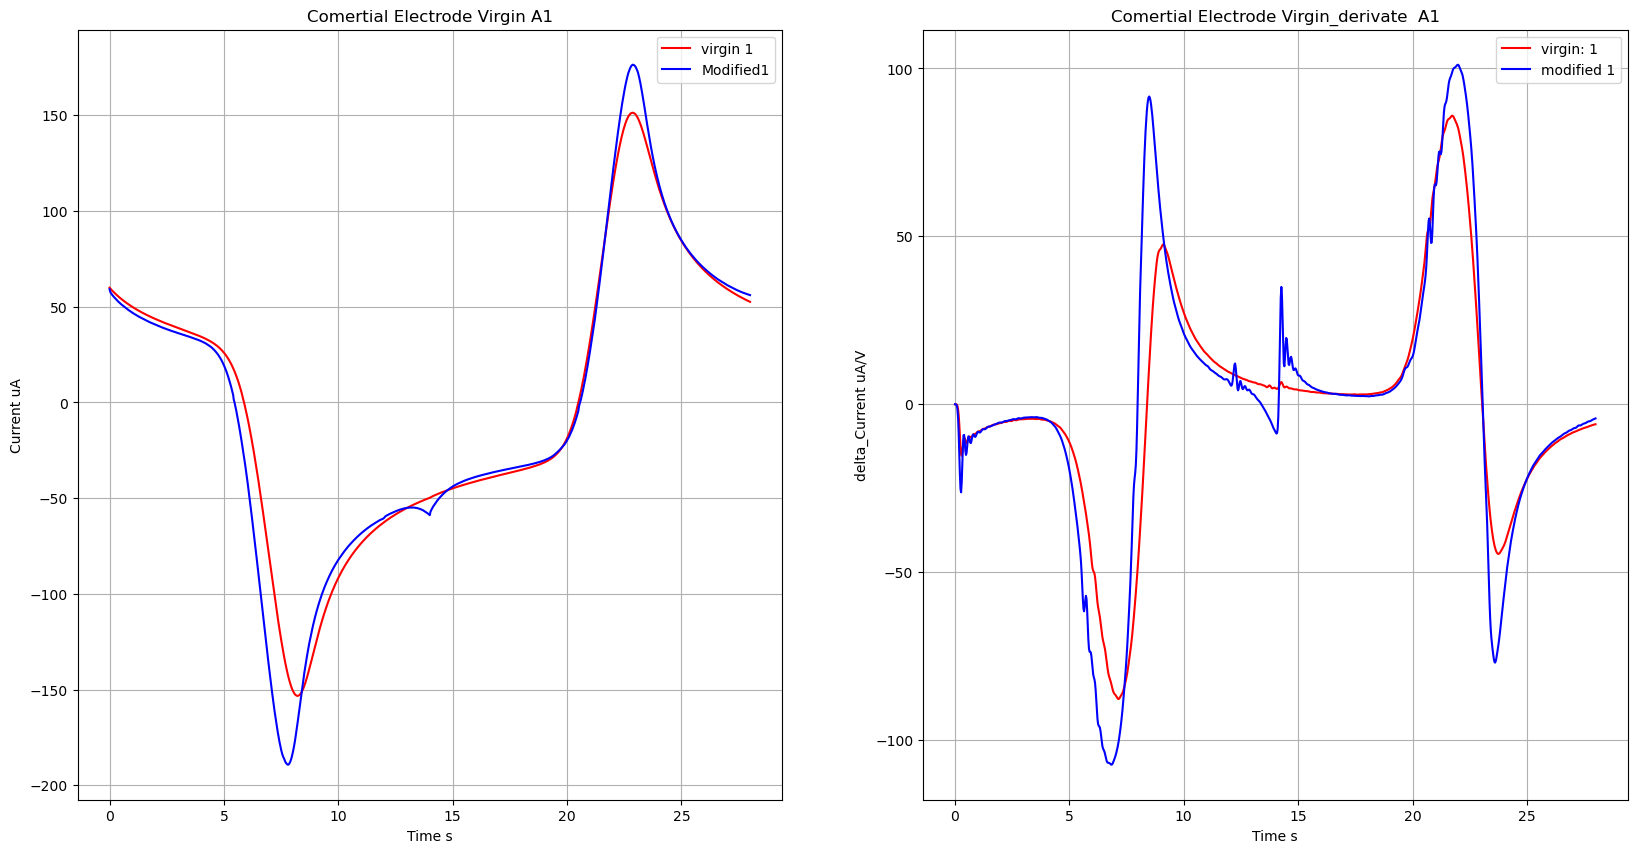

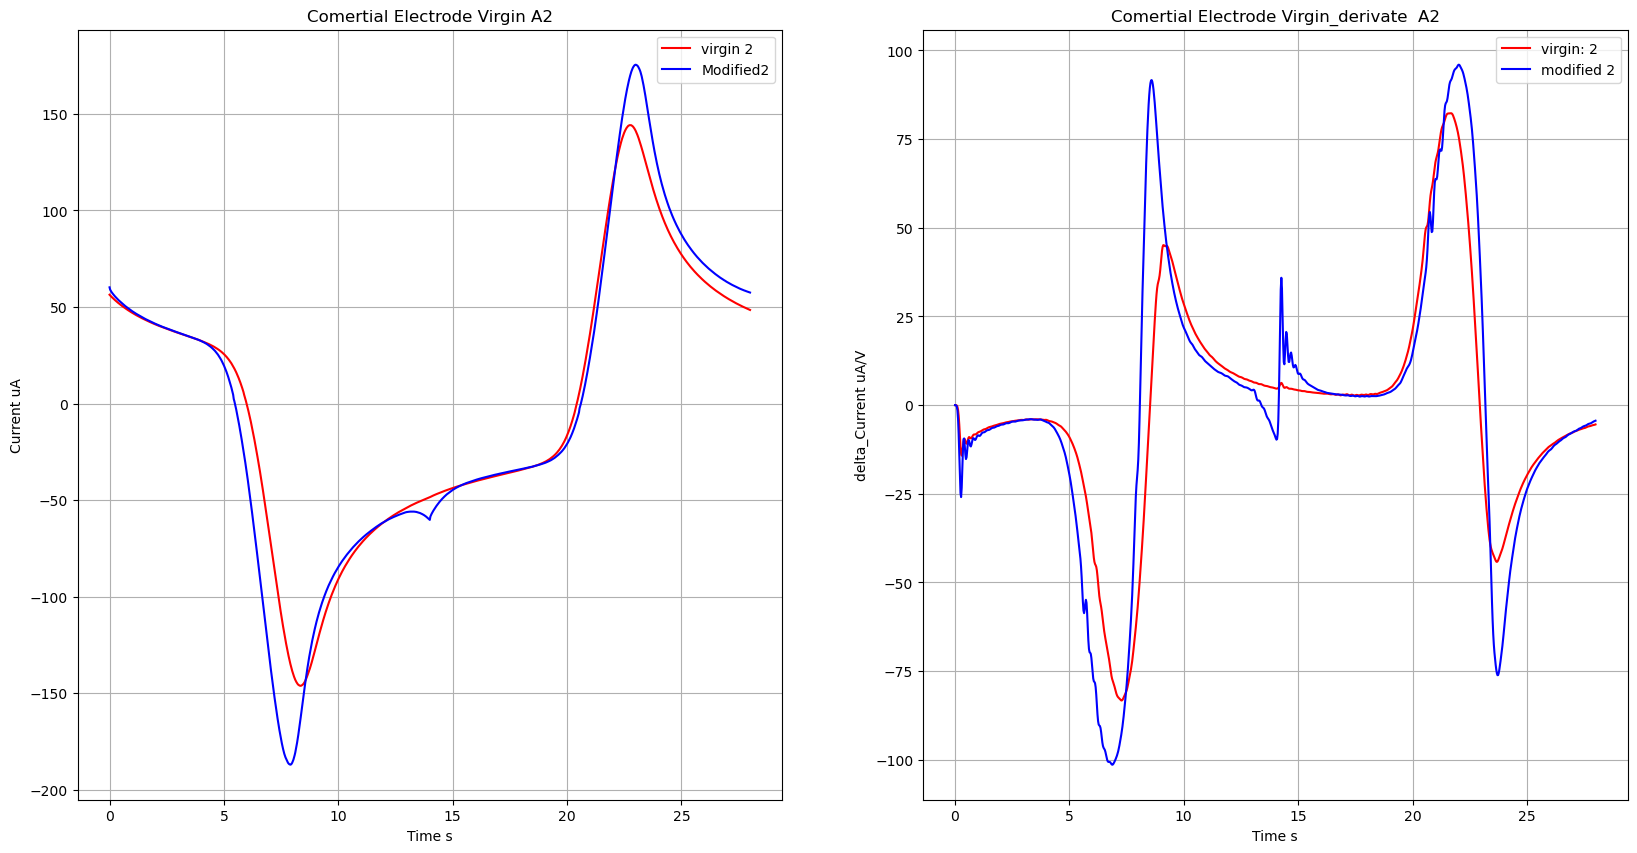

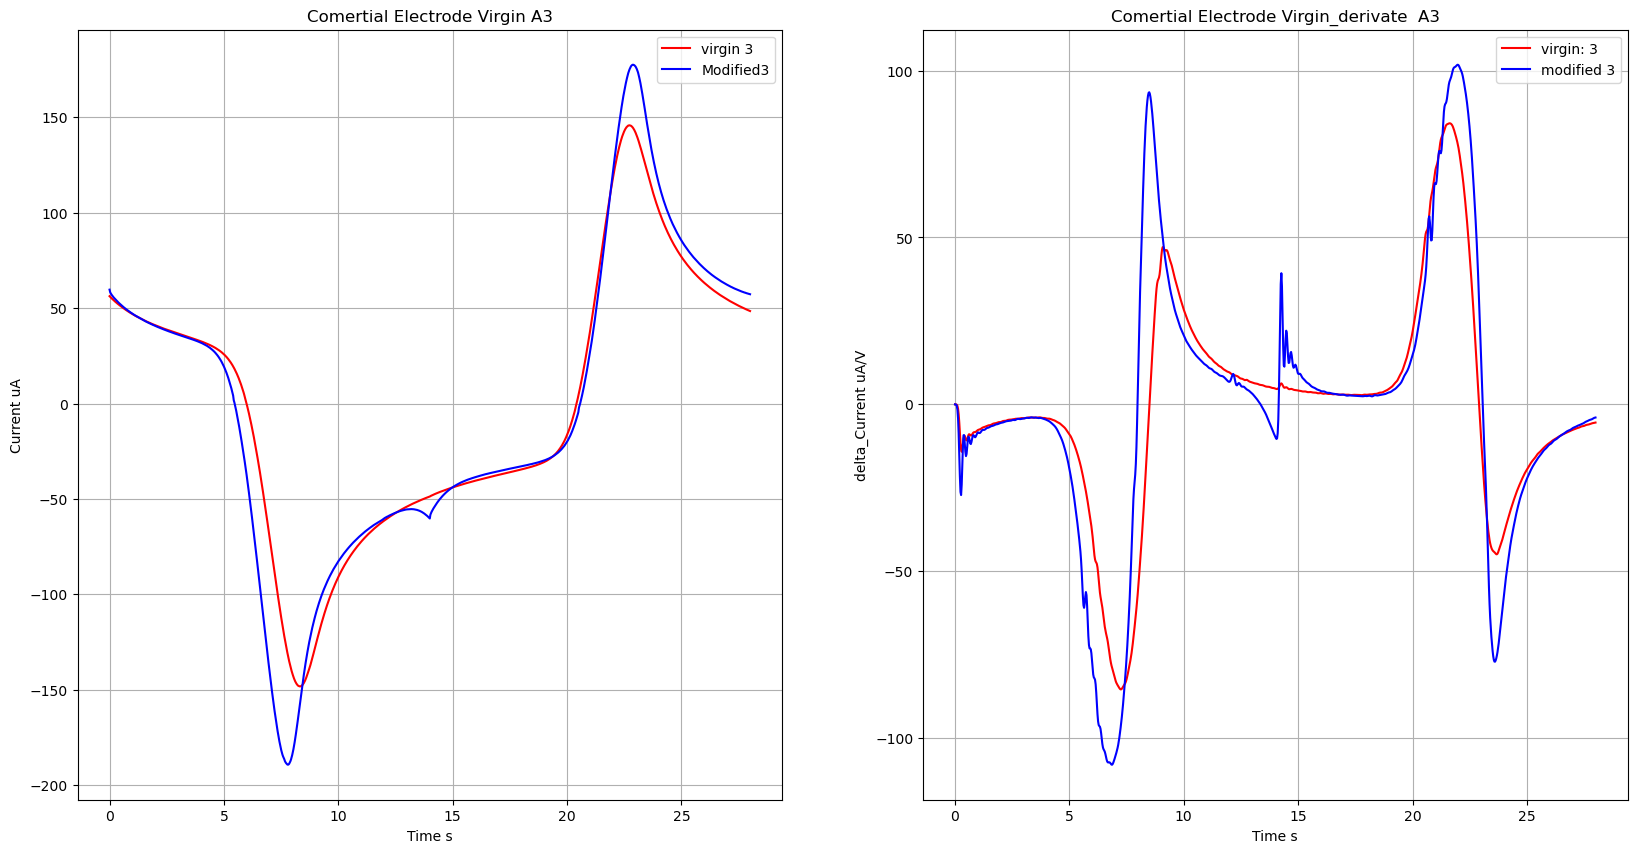

In [17]:
# Dados de eletrodos comerciais sem rodamina
charge_commertial = []
charge_commertial_rod = []
commertial_derivate_virgin_list = []
commertial_derivate_rod_list = []

time = getTime(0.075, potential_comertial_elec)

for i in range (1, comertial_electrode.shape[1]):
    
    current = comertial_electrode.iloc[:, i].values
    current_rod = comertial_rodamine.iloc[:, i].values
    
    d, derivate_virgin = derivate(time, current, True)
    e, derivate_rod  = derivate(time, current_rod, True)
    
    commertial_derivate_virgin_list.append(derivate_virgin)
    commertial_derivate_rod_list.append(derivate_rod)
    
    charge_commertial.append(getTotalCharge(current, time))
    charge_commertial_rod.append(getTotalCharge(current_rod, time))
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax1.set_title("Comertial Electrode Virgin " + comertial_electrode.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Time s")
    ax1.grid(True)
        
    ax2.set_title("Comertial Electrode Virgin_derivate  " + comertial_electrode.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Time s")
        
    ax2.grid(True)        
          
    ax1.plot(time, current, color='r', label="virgin " + str(i))
    ax1.plot(time, current_rod, color='b', label="Modified" + str(i))   
    ax1.legend()
    
    ax2.plot(time, derivate_virgin, color='r', label="virgin: " + str(i))
    ax2.plot(time, derivate_rod, color='b', label="modified " + str(i))
    
    
    ax2.legend()
    
plt.show()

## Observando a primeira derivada do eletrodo comercial modificado e não modificado

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


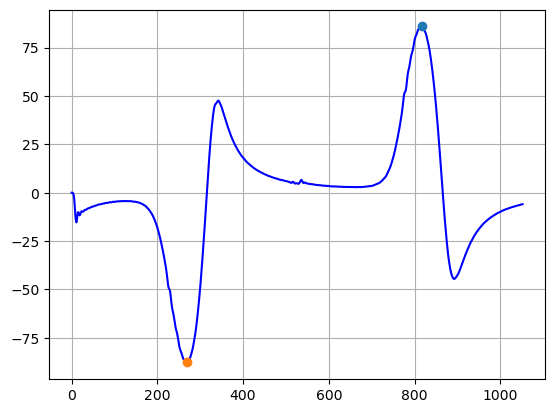

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


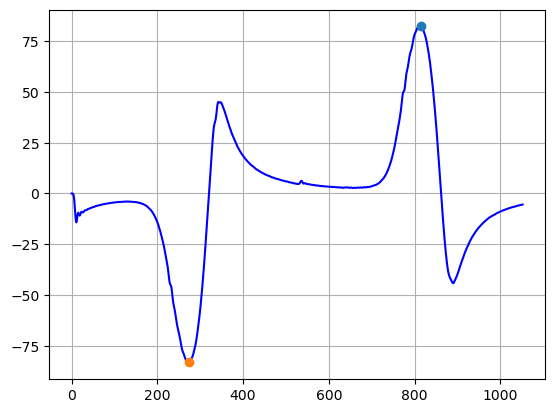

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


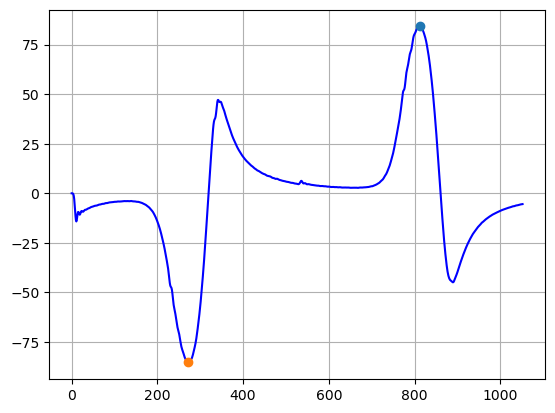

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


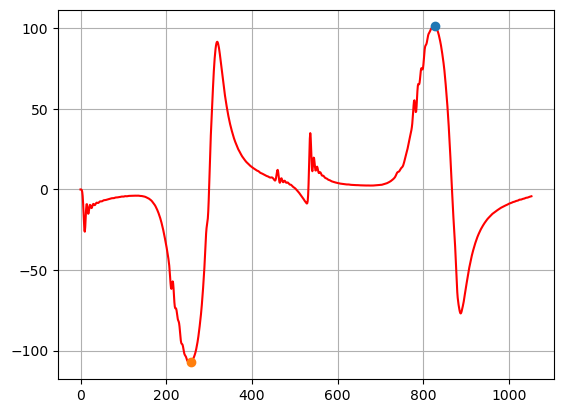

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


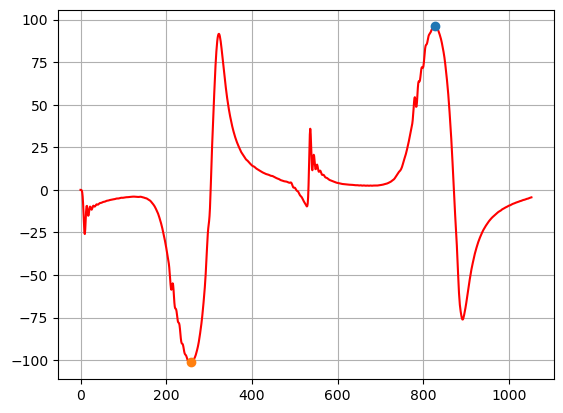

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


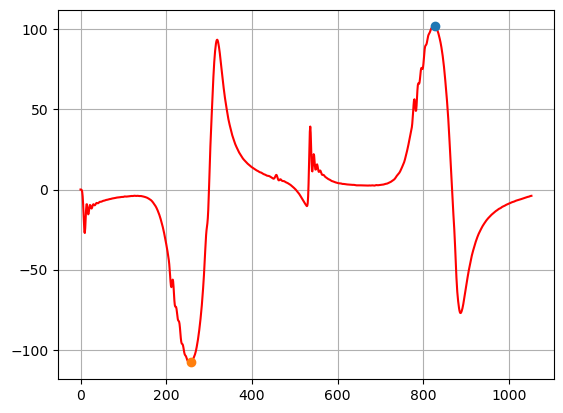

In [18]:
# Eletrodo virgem 
comertial_peak_current_anodic_derivate_virgin = []
comertial_peak_current_cathodic_derivate_virgin = []
comertial_peak_current_anodic_derivate_rodamine = []
comertial_peak_current_cathodic_derivate_rodamine = []

for d in commertial_derivate_virgin_list:
    (anodic, cathodic) = getAnodicAndCathodicArguments(d, fp, ox_inf = 750, ox_sup = 850, red_inf = 200, red_sup = 300)
    comertial_peak_current_anodic_derivate_virgin.append(d[anodic])
    comertial_peak_current_cathodic_derivate_virgin.append(d[cathodic])
    
    plt.plot(d, color='b')
    plt.plot(anodic, d[anodic], marker='o')
    plt.plot(cathodic, d[cathodic], marker='o')
    plt.grid()
    plt.show()
    
# Eletrodo modificado
for d in commertial_derivate_rod_list:
    (anodic, cathodic) = getAnodicAndCathodicArguments(d, fp, ox_inf = 750, ox_sup = 850, red_inf = 200, red_sup = 300)
    comertial_peak_current_anodic_derivate_rodamine.append(d[anodic])
    comertial_peak_current_cathodic_derivate_rodamine.append(d[cathodic])
    plt.plot(d, color='r')
    plt.plot(anodic, d[anodic], marker='o')
    plt.plot(cathodic, d[cathodic], marker='o')
    plt.grid()
    plt.show()

In [19]:
# Plota as classes de features em azul = positivo e vermelho = negativo
def plot_classes(positive, negative):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(np.linspace(0, len(positive), len(positive)), positive, color='b', label='Positive')
    ax.scatter(np.linspace(0, len(negative), len(negative)), negative, color='r', label='Negative')
    plt.legend()
    plt.show()


# Análise estatística do eletrodo comercial

* 1 - Corrente de pico anódica
* 2 - Corrente de pico catódica
* 3 - Diferença entre corrente de pico anódica e catódica
* 4 - Diferença entre potencial anódico e catódico
* 5 - Carga
* 6 - Pico da derivada anódica
* 7 - Pico da derivada catódica



Eletrodo Virgem

Mean: -149.20766666666668
Median: -148.24
Std: 3.012808914543953
Maximum: -146.098
Minumum: -153.285


Eletrodo Modificado

Mean: -188.50233333333335
Median: -189.247
Std: 1.0922393917493058
Maximum: -186.958
Minumum: -189.302


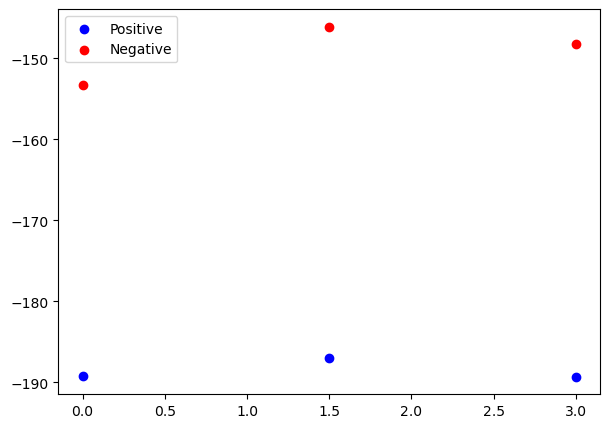

MannwhitneyuResult(statistic=9.0, pvalue=0.1)

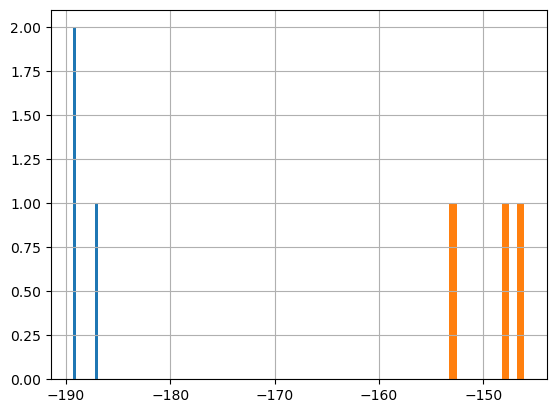

In [20]:
# Corrente Catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_elec_cathodic_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_elec_cathodic_current_rod))
plot_classes(comertial_elec_cathodic_current_rod, comertial_elec_cathodic_current)
pd.Series(comertial_elec_cathodic_current_rod).hist()
pd.Series(comertial_elec_cathodic_current).hist()
stats.mannwhitneyu(comertial_elec_cathodic_current, comertial_elec_cathodic_current_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 147.10166666666666
Median: 145.832
Std: 3.0574346908624035
Maximum: 151.316
Minumum: 144.157


Eletrodo Modificado

Mean: 176.472
Median: 176.393
Std: 0.8839913272576085
Maximum: 177.592
Minumum: 175.431


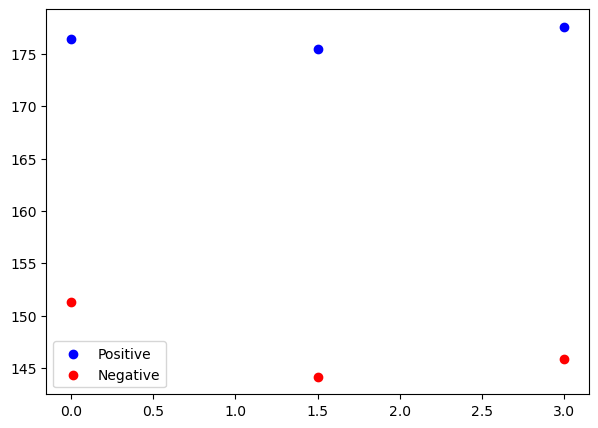

MannwhitneyuResult(statistic=0.0, pvalue=0.1)

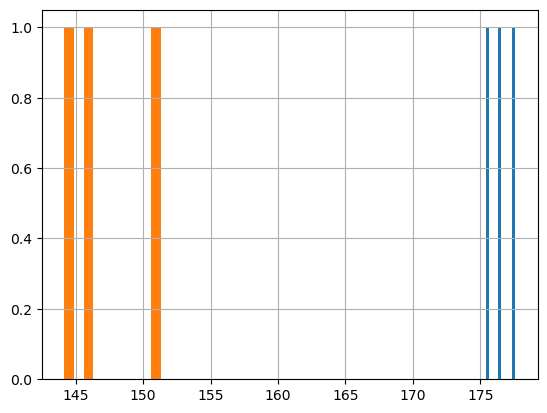

In [21]:
# Corrente Anódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_elec_anodic_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_elec_anodic_current_rod))
plot_classes(comertial_elec_anodic_current_rod, comertial_elec_anodic_current)
pd.Series(comertial_elec_anodic_current_rod).hist()
pd.Series(comertial_elec_anodic_current).hist()
stats.mannwhitneyu(comertial_elec_anodic_current, comertial_elec_anodic_current_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 296.3093333333333
Median: 294.072
Std: 6.066639615324306
Maximum: 304.601
Minumum: 290.255


Eletrodo Modificado

Mean: 364.97433333333333
Median: 365.64
Std: 1.898436257086923
Maximum: 366.894
Minumum: 362.389


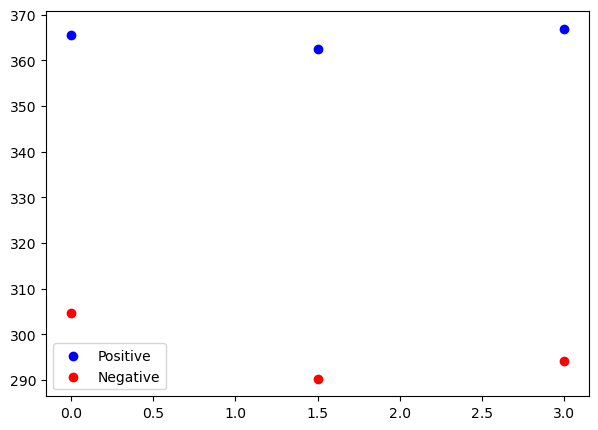

MannwhitneyuResult(statistic=9.0, pvalue=0.1)

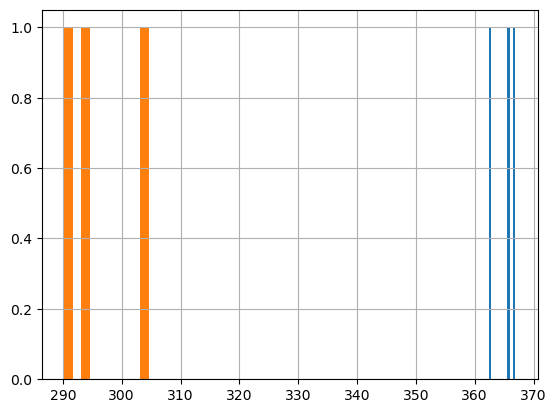

In [22]:
# Difereça entre corrente de pico anódica e catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_elec_diff_ano_cat_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_elec_diff_ano_cat_current_rod))
plot_classes(comertial_elec_diff_ano_cat_current_rod, comertial_elec_diff_ano_cat_current)
pd.Series(comertial_elec_diff_ano_cat_current_rod).hist()
pd.Series(comertial_elec_diff_ano_cat_current).hist()
stats.mannwhitneyu(comertial_elec_diff_ano_cat_current_rod, comertial_elec_diff_ano_cat_current, alternative='two-sided')

Eletrodo Virgem

Mean: 0.23158803333333333
Median: 0.23158800000000002
Std: 0.0016299312998474
Maximum: 0.23358430000000002
Minumum: 0.2295918


Eletrodo Modificado

Mean: 0.2069654
Median: 0.20164179999999998
Std: 0.007528707320649412
Maximum: 0.2176126
Minumum: 0.20164179999999998


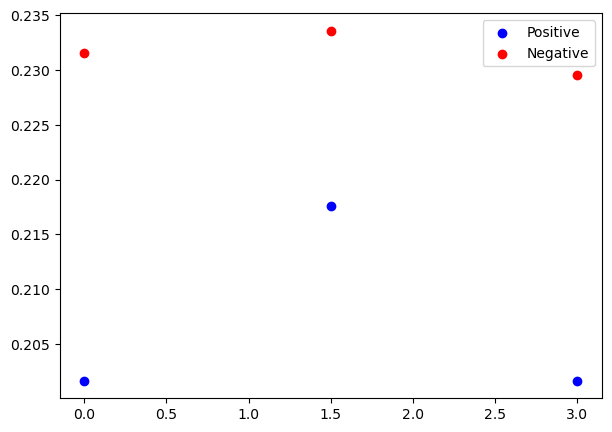

MannwhitneyuResult(statistic=0.0, pvalue=0.07652250047505922)

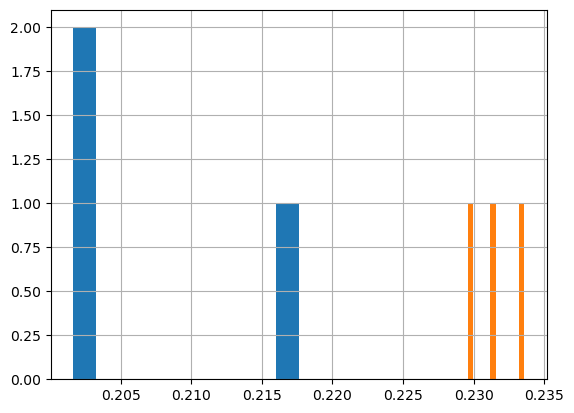

In [23]:
# Difereça entre corrente de pico anódica e catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_elec_diff_ano_cat_potential))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_elec_diff_ano_cat_potential_rod))
plot_classes(comertial_elec_diff_ano_cat_potential_rod, comertial_elec_diff_ano_cat_potential)
pd.Series(comertial_elec_diff_ano_cat_potential_rod).hist()
pd.Series(comertial_elec_diff_ano_cat_potential).hist()
stats.mannwhitneyu(comertial_elec_diff_ano_cat_potential_rod, comertial_elec_diff_ano_cat_potential, alternative='two-sided')

Eletrodo Virgem

Mean: -40.902107786791966
Median: -40.55824313963467
Std: 1.4482228123171215
Maximum: -39.32551450303737
Minumum: -42.82256571770387


Eletrodo Modificado

Mean: -111.76631056881224
Median: -113.99281790581671
Std: 3.561355836994608
Maximum: -106.74065585935801
Minumum: -114.56545794126203


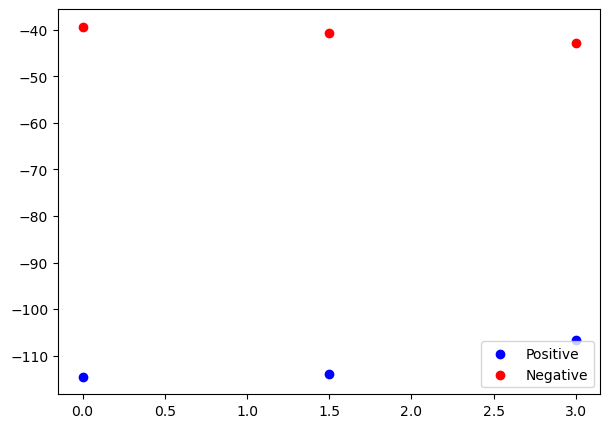

MannwhitneyuResult(statistic=0.0, pvalue=0.1)

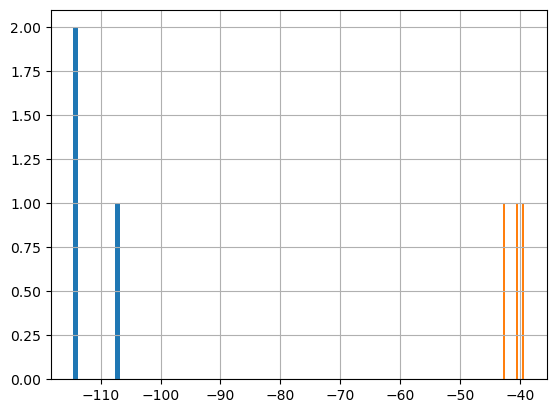

In [24]:
# Difereça entre potencial de pico anódica e catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(charge_commertial))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(charge_commertial_rod))
plot_classes(charge_commertial_rod, charge_commertial)
pd.Series(charge_commertial_rod).hist()
pd.Series(charge_commertial).hist()
stats.mannwhitneyu(charge_commertial_rod, charge_commertial, alternative='two-sided')

Eletrodo Virgem

Mean: 84.1375050829122
Median: 84.17799467619989
Std: 1.4914940675264439
Maximum: 85.9436234141338
Minumum: 82.29089715840293


Eletrodo Modificado

Mean: 99.60269040122914
Median: 101.116197326086
Std: 2.58723562175839
Maximum: 101.73083812169261
Minumum: 95.96103575590882


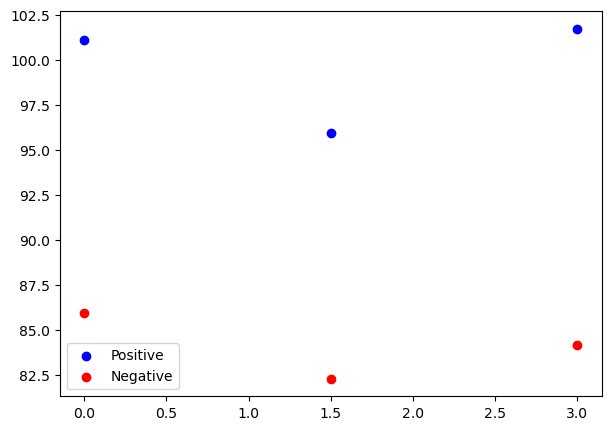

MannwhitneyuResult(statistic=9.0, pvalue=0.1)

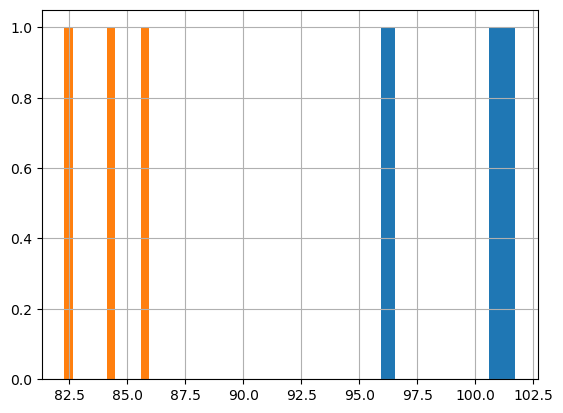

In [25]:
# Pico da derivada anódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_peak_current_anodic_derivate_virgin))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_peak_current_anodic_derivate_rodamine))
plot_classes(comertial_peak_current_anodic_derivate_rodamine, comertial_peak_current_anodic_derivate_virgin)
pd.Series(comertial_peak_current_anodic_derivate_rodamine).hist()
pd.Series(comertial_peak_current_anodic_derivate_virgin).hist()
stats.mannwhitneyu(comertial_peak_current_anodic_derivate_rodamine, comertial_peak_current_anodic_derivate_virgin, alternative='two-sided')

Eletrodo Virgem

Mean: -85.47435432192283
Median: -85.37416972432025
Std: 1.8485245061130733
Maximum: -83.26213882571628
Minumum: -87.78675441573198


Eletrodo Modificado

Mean: -105.55575672074463
Median: -107.35804968295706
Std: 2.968224305036287
Maximum: -101.3714199700558
Minumum: -107.93780050922099


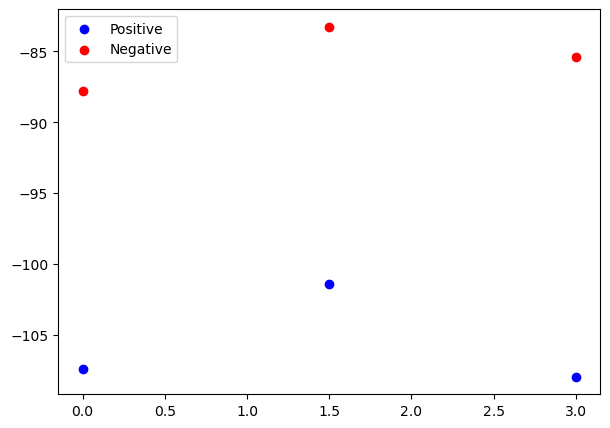

MannwhitneyuResult(statistic=0.0, pvalue=0.1)

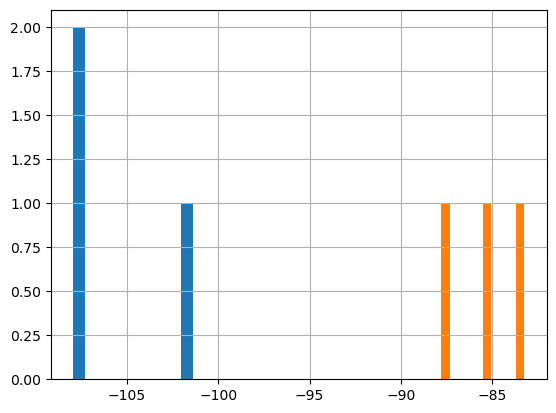

In [26]:
# Pico da derivada catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(comertial_peak_current_cathodic_derivate_virgin))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(comertial_peak_current_cathodic_derivate_rodamine))
plot_classes(comertial_peak_current_cathodic_derivate_rodamine, comertial_peak_current_cathodic_derivate_virgin)
pd.Series(comertial_peak_current_cathodic_derivate_rodamine).hist()
pd.Series(comertial_peak_current_cathodic_derivate_virgin).hist()
stats.mannwhitneyu(comertial_peak_current_cathodic_derivate_rodamine, comertial_peak_current_cathodic_derivate_virgin, alternative='two-sided')

# Estudo dos eletrodos de Polimida

In [27]:
polimid_rodamine_df.head()

,V,A4 ac+rod becker 30s,C3 ac+rod becker 30s,D2 ac+rod becker 30s,E5 ac+rod becker 30s
0,0.550022,42.6413,44.4907,43.3371,43.6301
1,0.548026,41.7258,43.4470,42.1836,42.7695
2,0.546029,41.2589,42.9252,41.6983,42.2110
3,0.544033,40.8194,42.5132,41.2039,41.7624
4,0.542036,40.5447,42.1286,40.7828,41.4328


In [28]:
polimid_df.head()

,V,B5 13071,C2 13071,D6 13071,E3 13071
0,0.550022,49.0867,48.9860,51.9066,48.5100
1,0.548026,45.6168,45.3880,48.4001,44.7837
2,0.546029,44.2252,43.9048,46.8620,43.2639
3,0.544033,43.3555,43.0350,45.9464,42.3667
4,0.542036,42.6871,42.3575,45.2689,41.6983


In [29]:
print(polimid_df.columns)
print(polimid_rodamine_df.columns)

Index(['V', 'B5 13071', 'C2 13071', 'D6 13071', 'E3 13071'], dtype='object')
Index(['V', 'A4 ac+rod becker 30s', 'C3 ac+rod becker 30s',
       'D2 ac+rod becker 30s', 'E5 ac+rod becker 30s'],
      dtype='object')


In [30]:
# Dados de eletrodos de polimida sem modificação
poli_elec_derivate_df = pd.DataFrame(columns = polimid_df.columns)
potential_poli_elec = polimid_df.loc[:, polimid_df.columns[0]].values
poli_elec_derivate_df[polimid_df.columns[0]] = potential_poli_elec
poli_elec_anodic_current = []
poli_elec_cathodic_current = []
poli_elec_diff_ano_cat_potential = []
poli_elec_diff_ano_cat_current = []

In [31]:
# Dados de eletrodos de polimida sem modificação
poli_elec_derivate_rod_df = pd.DataFrame(columns = polimid_rodamine_df.columns)
poli_elec_anodic_current_rod = []
poli_elec_cathodic_current_rod = []
poli_elec_diff_ano_cat_potential_rod = []
poli_elec_diff_ano_cat_current_rod = []
potential_poli_elec_rod = polimid_rodamine_df.loc[:, polimid_rodamine_df.columns[0]].values
poli_elec_derivate_rod_df[polimid_rodamine_df.columns[0]] = potential_poli_elec_rod

Critical frequency 0.026575476529160976
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
Critical frequency 0.026575476529160976
Critical frequency 0.026575476529160976
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..
[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


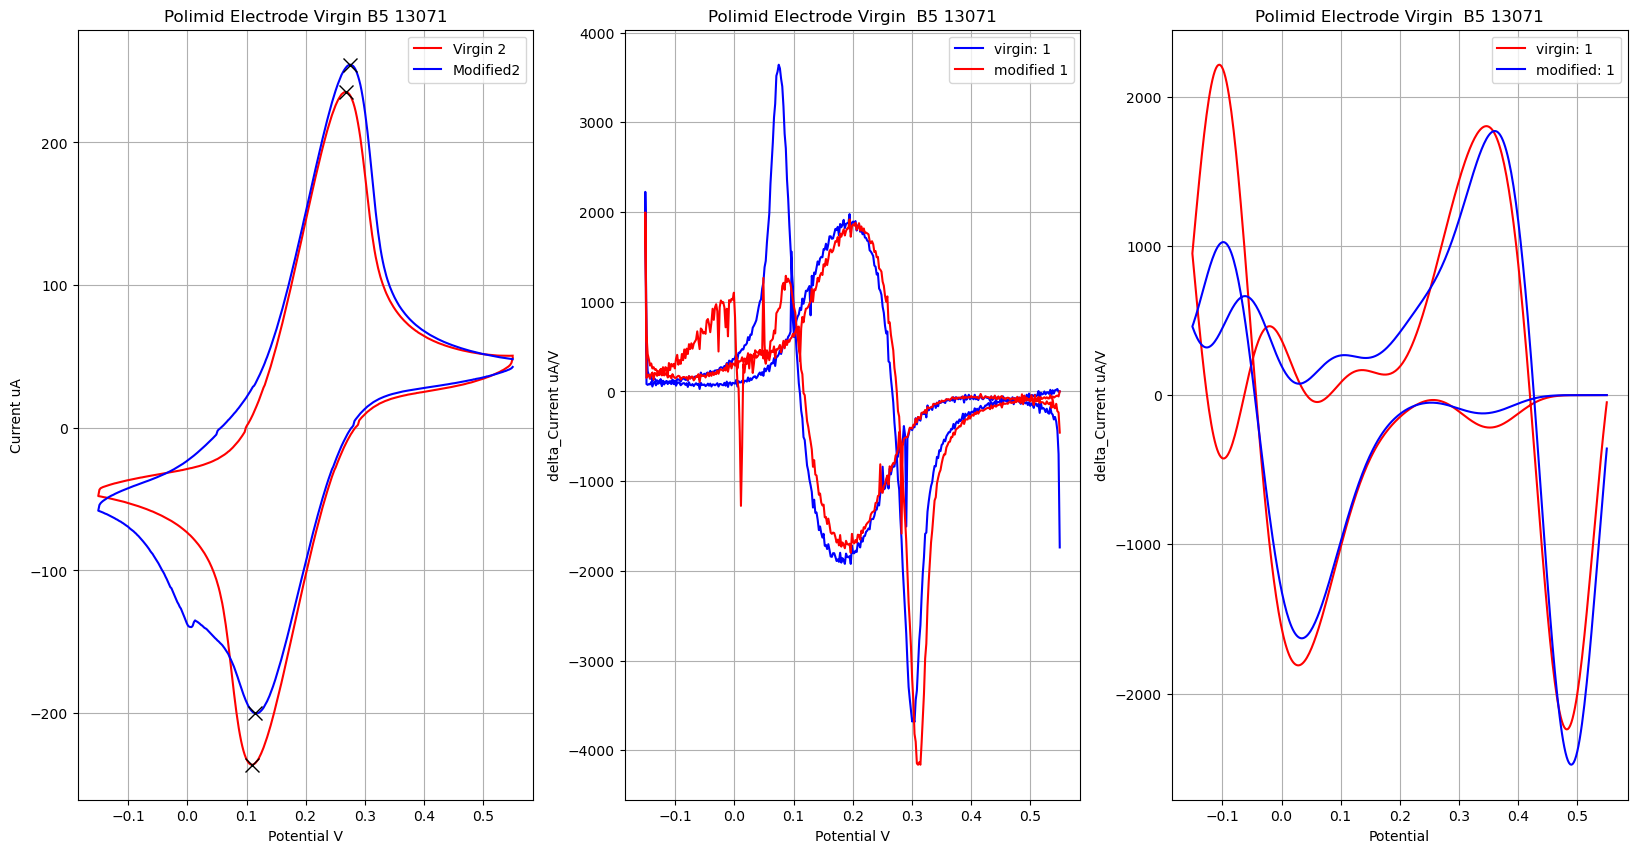

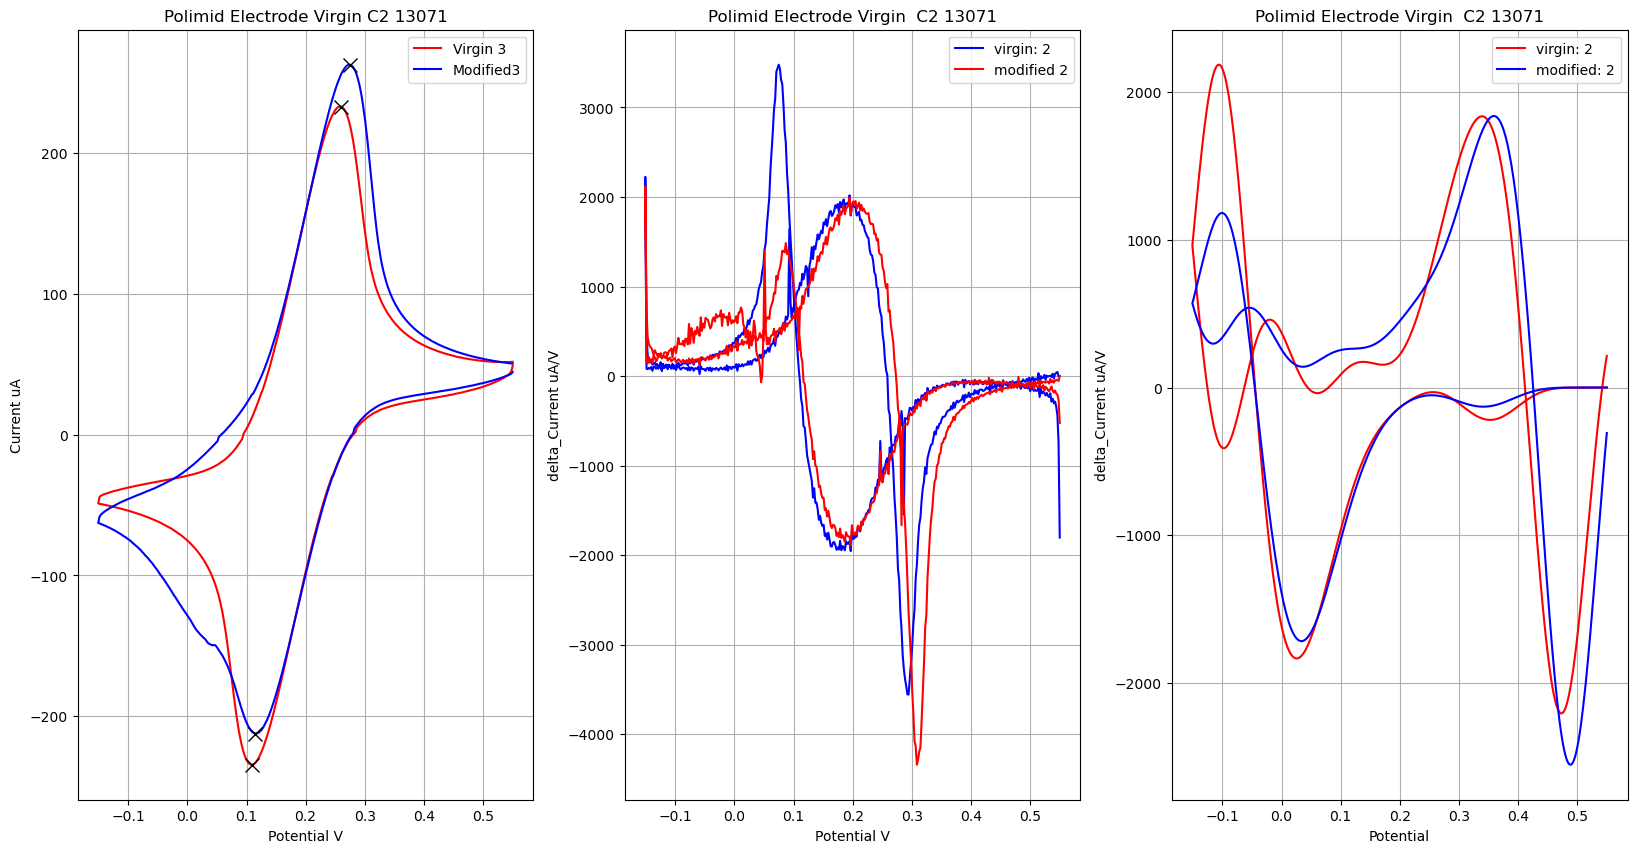

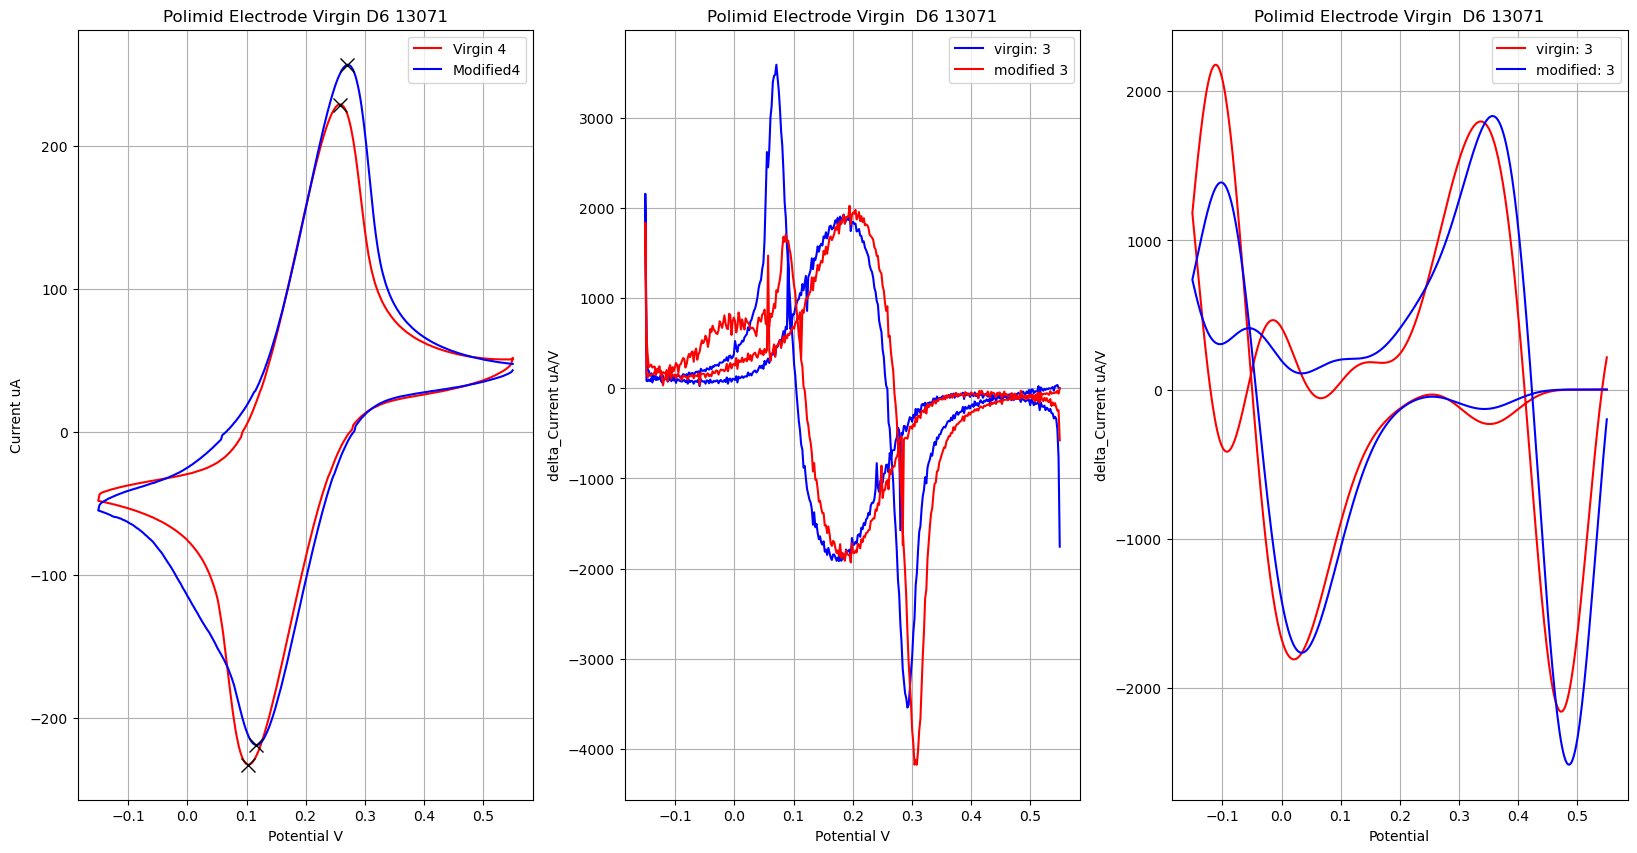

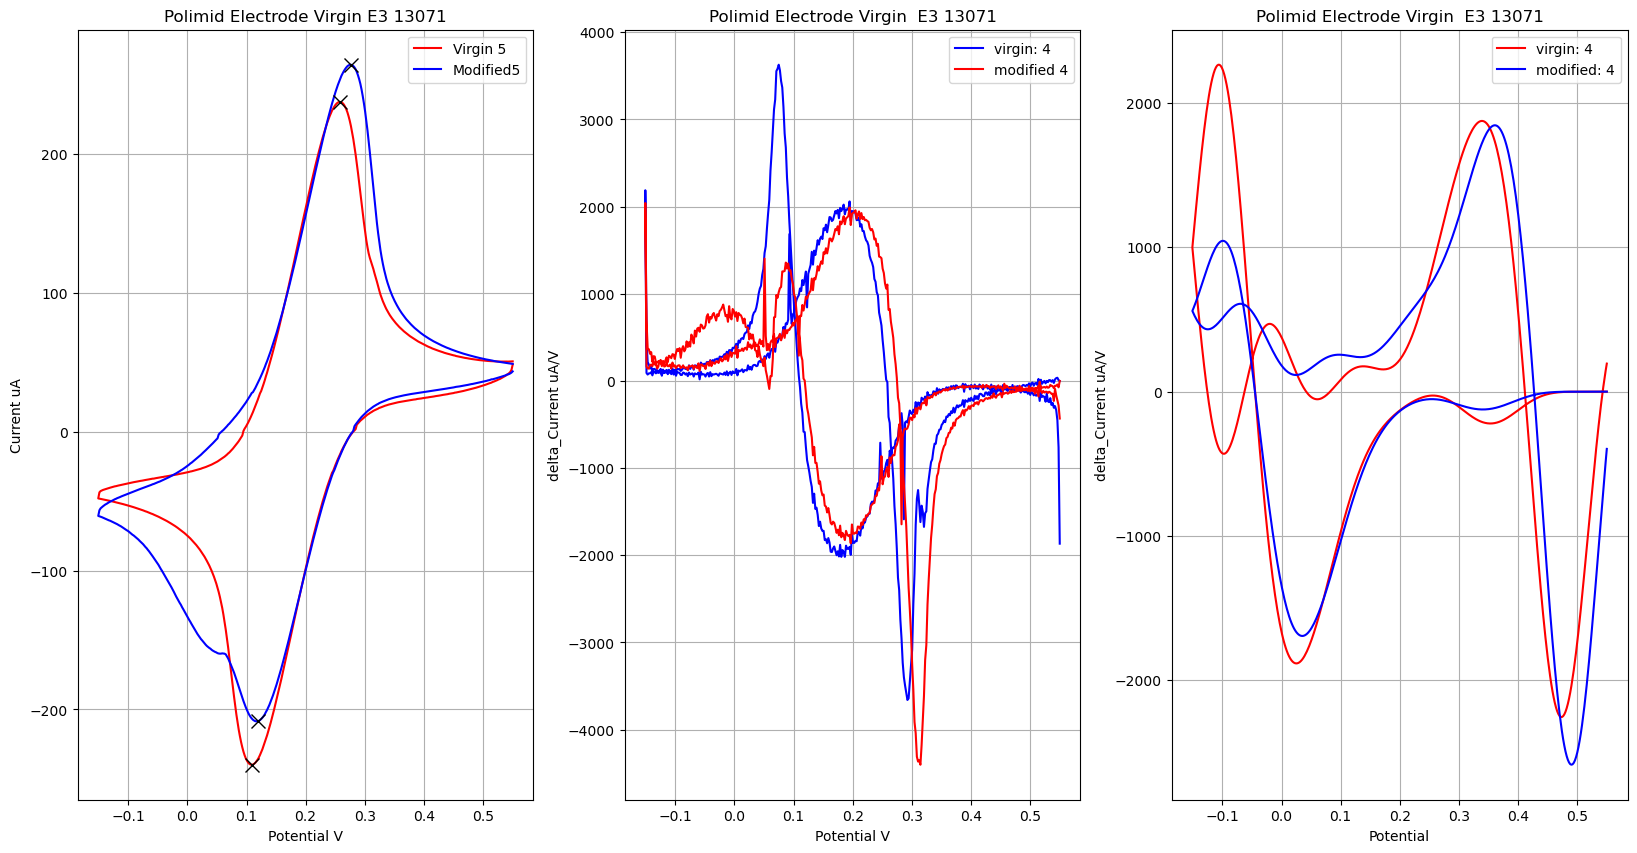

In [32]:
plot_peak = True

for i in range (1, polimid_df.shape[1]):
    
    current = polimid_df.iloc[:, i].values
    current_rod = polimid_rodamine_df.iloc[:, i].values

    current_derivate, derived_current_filtered = derivate(potential_poli_elec, current)
    current_derivate_rod, derived_current_filtered_rod = derivate(potential_poli_elec_rod, current_rod)

    poli_elec_derivate_df[polimid_df.columns[i]] = derived_current_filtered
    poli_elec_derivate_rod_df[polimid_rodamine_df.columns[i]] = derived_current_filtered_rod

    (anodic, cathodic) = getAnodicAndCathodicArguments(current, fp, ox_inf = 500, ox_sup = 600, red_inf = 200, red_sup = 250)
    (anodic_rod, cathodic_rod) = getAnodicAndCathodicArguments(current_rod, fp, ox_inf = 500, ox_sup = 600, red_inf = 200, red_sup = 250)
    
    if (anodic_rod != -1 and cathodic_rod != -1):
        poli_elec_anodic_current_rod.append(current_rod[anodic_rod])
        poli_elec_cathodic_current_rod.append(current_rod[cathodic_rod])
        poli_elec_diff_ano_cat_current_rod.append(abs(current_rod[anodic_rod] - current_rod[cathodic_rod]))
        poli_elec_diff_ano_cat_potential_rod.append(abs(potential_poli_elec[anodic_rod] - potential_poli_elec[cathodic_rod]))
        
    elif (anodic_rod == -1):
         poli_elec_anodic_current_rod.append(np.nan)
         poli_elec_cathodic_current_rod.append(np.nan)
         poli_elec_diff_ano_cat_current_rod.append(np.nan)
         poli_elec_diff_ano_cat_potential_rod.append(current_rod[cathodic_rod])
         
    elif (cathodic_rod == -1):
        poli_elec_anodic_current_rod.append(current_rod[anodic_rod])
        poli_elec_cathodic_current_rod.append(np.nan)
        poli_elec_diff_ano_cat_current_rod.append(np.nan)
        poli_elec_diff_ano_cat_potential_rod.append(np.nan)
    
    
    if (anodic != -1 and cathodic != -1):
        poli_elec_anodic_current.append(current[anodic])
        poli_elec_cathodic_current.append(current[cathodic])
        poli_elec_diff_ano_cat_current.append(abs(current[anodic] - current[cathodic]))
        poli_elec_diff_ano_cat_potential.append(abs(potential_poli_elec[anodic] - potential_poli_elec[cathodic]))
        plot_peak = True
        
    elif (anodic == -1):
         poli_elec_anodic_current.append(np.nan)
         poli_elec_cathodic_current.append(np.nan)
         poli_elec_diff_ano_cat_current.append(np.nan)
         poli_elec_diff_ano_cat_potential.append(current[cathodic])
         
    elif (cathodic == -1):
        poli_elec_anodic_current.append(current[anodic])
        poli_elec_cathodic_current.append(np.nan)
        poli_elec_diff_ano_cat_current.append(np.nan)
        poli_elec_diff_ano_cat_potential.append(np.nan)

 
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
    ax1.set_title("Polimid Electrode Virgin " + polimid_df.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Potential V")
    ax1.grid(True)
        
    ax2.set_title("Polimid Electrode Virgin  " + polimid_df.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Potential V")
        
    ax2.grid(True)
        
    ax3.set_title("Polimid Electrode Virgin  " + polimid_df.columns[i])
    ax3.set_ylabel("delta_Current uA/V")
    ax3.set_xlabel("Potential")
        
    ax3.grid(True)
        
          
    ax1.plot(potential_poli_elec, current, color='r', label="Virgin " + str(i + 1))
    ax1.plot(potential_poli_elec, current_rod, color='b', label="Modified" + str(i + 1))

    if (plot_peak):
        ax1.plot(potential_poli_elec[anodic], current[anodic], marker="x", markersize=10, markeredgecolor="black")
        ax1.plot(potential_poli_elec[cathodic], current[cathodic], marker="x", markersize=10, markeredgecolor="black")

        ax1.plot(potential_poli_elec[anodic_rod], current_rod[anodic_rod], marker="x", markersize=10, markeredgecolor="black")
        ax1.plot(potential_poli_elec[cathodic_rod], current_rod[cathodic_rod], marker="x", markersize=10, markeredgecolor="black")
        
    ax1.legend() 
    ax2.plot(potential_poli_elec, current_derivate, color='b', label="virgin: " + str(i))
    ax2.plot(potential_poli_elec, current_derivate_rod, color='r', label="modified " + str(i))
    ax2.legend()
    #ax3.plot(potential_neg, derived_current_filtered, color=colors[plots], label="case: " + str(plots + 1))
    ax3.plot(potential_poli_elec, derived_current_filtered, color='r', label="virgin: " + str(i))
    ax3.plot(potential_poli_elec, derived_current_filtered_rod, color='b', label="modified: " + str(i))
    ax3.legend() 
    plot_peak = False
    
plt.show()

# Observando os gráficos dos eletrodos de Polimida em função do tempo

Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306
Critical frequency 0.26613333333333306


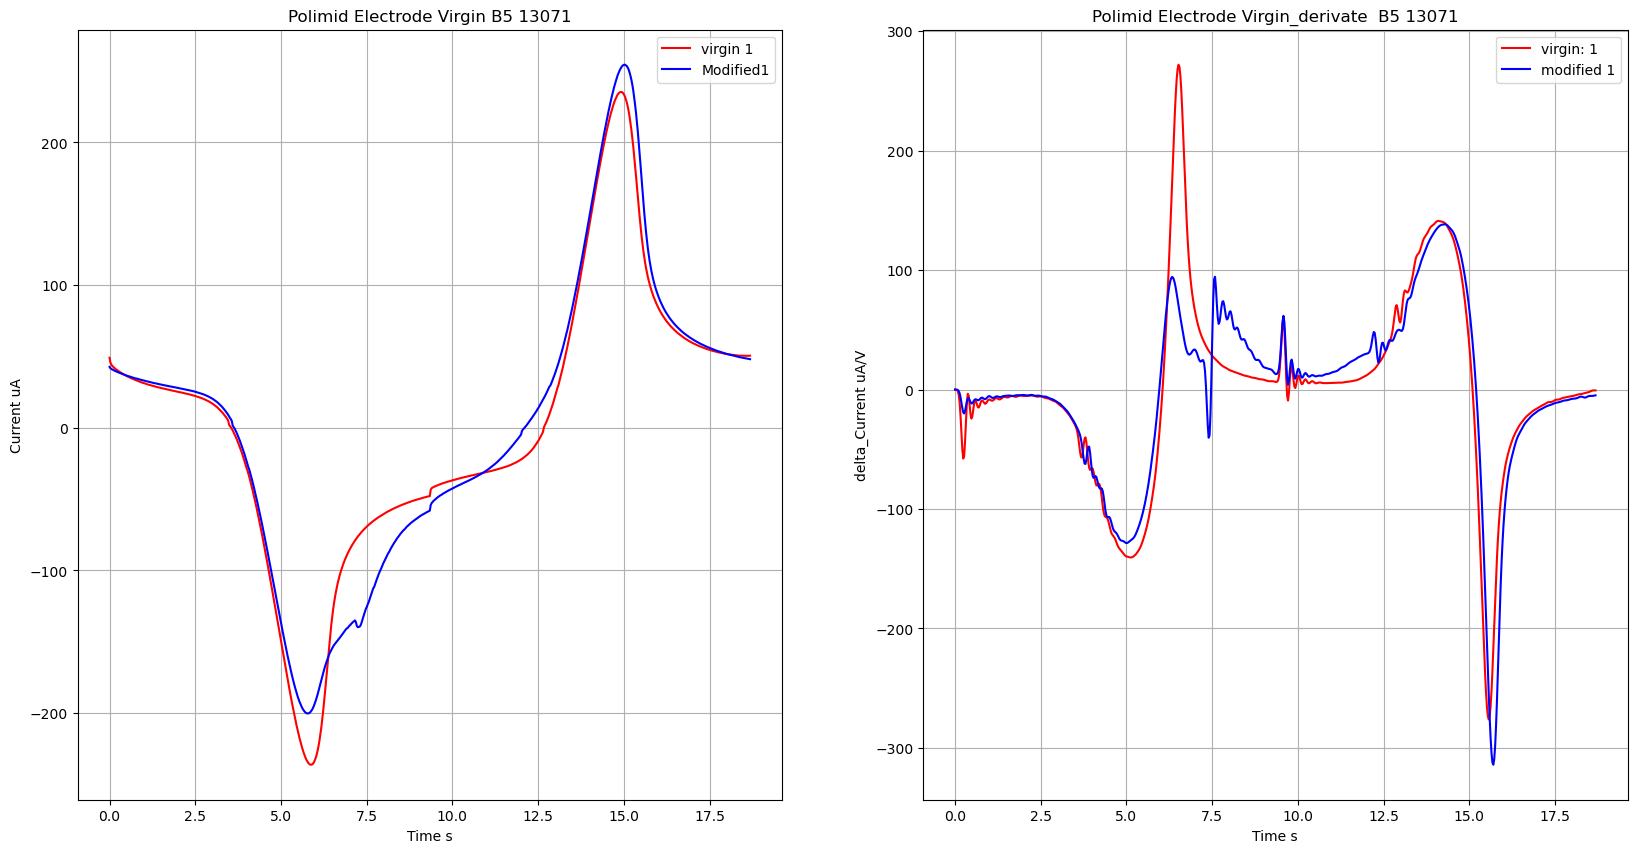

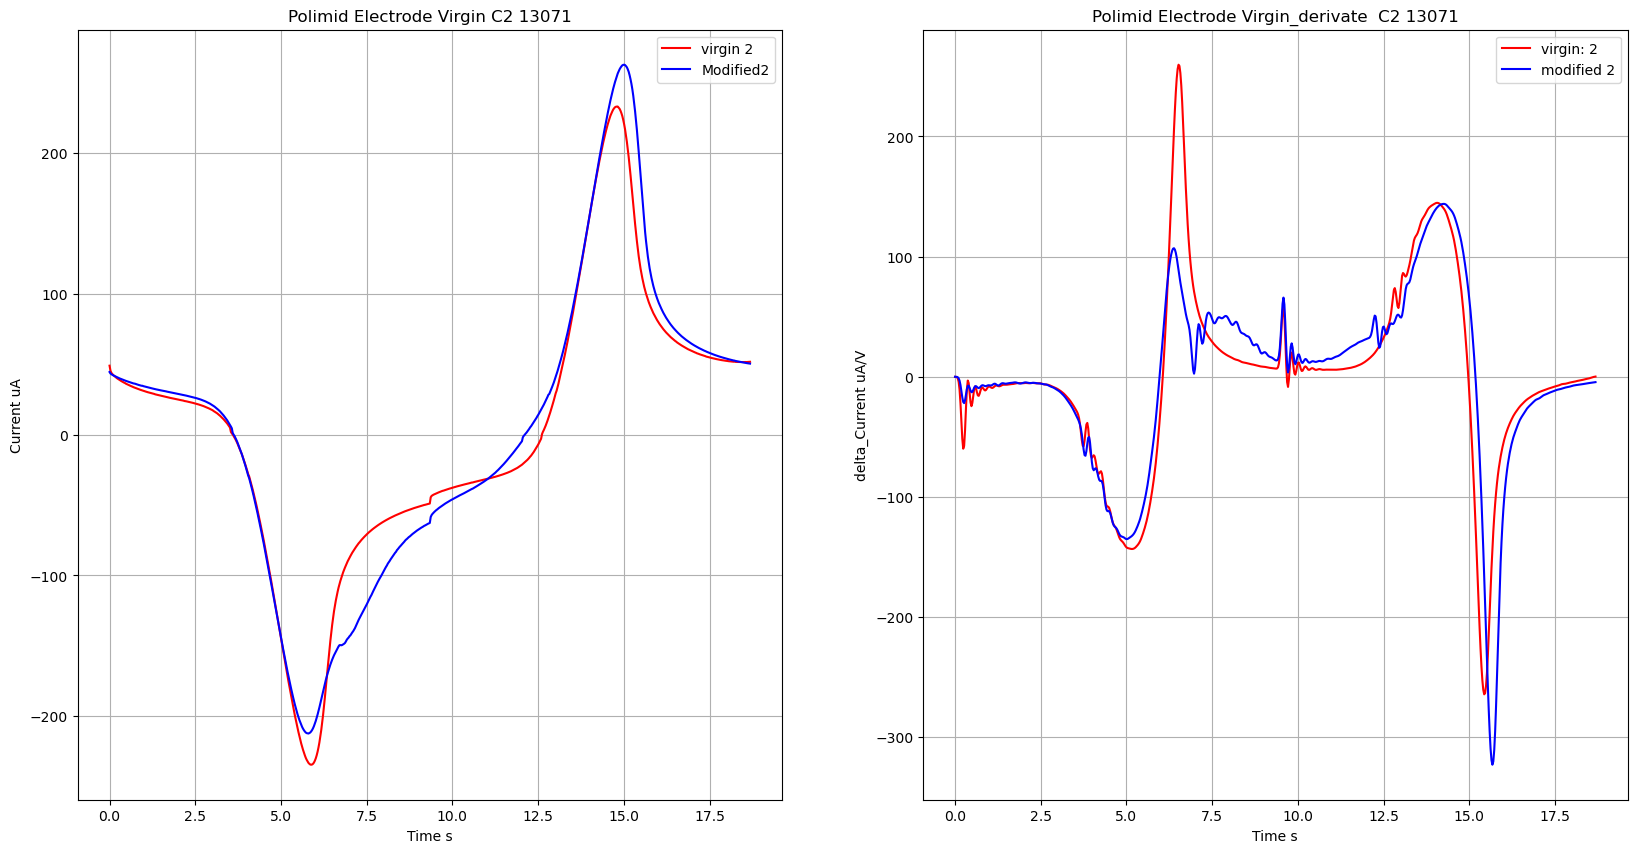

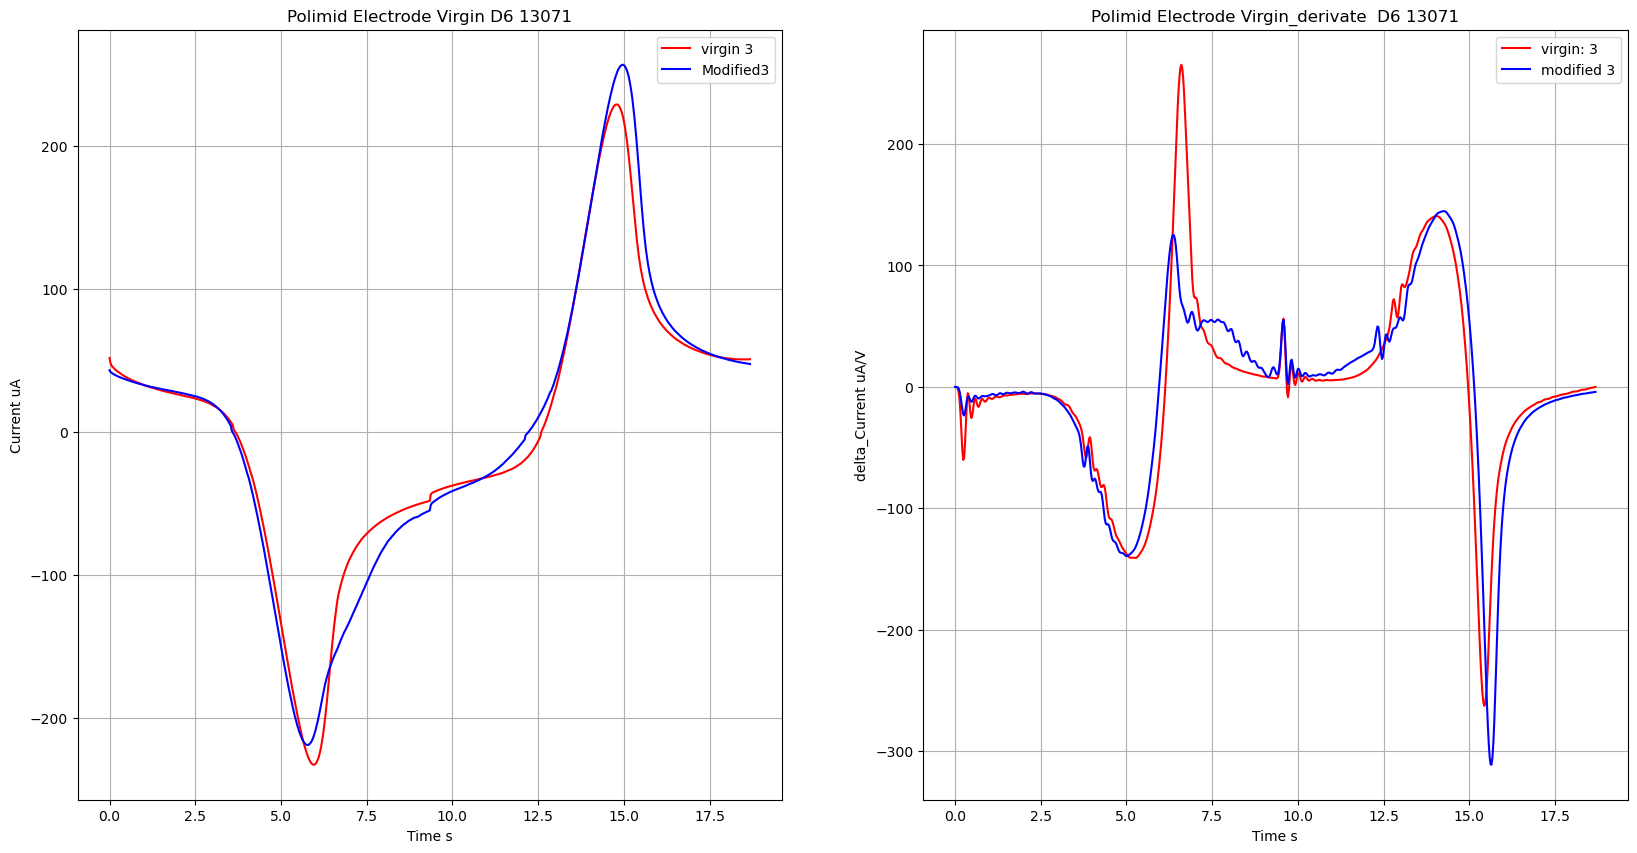

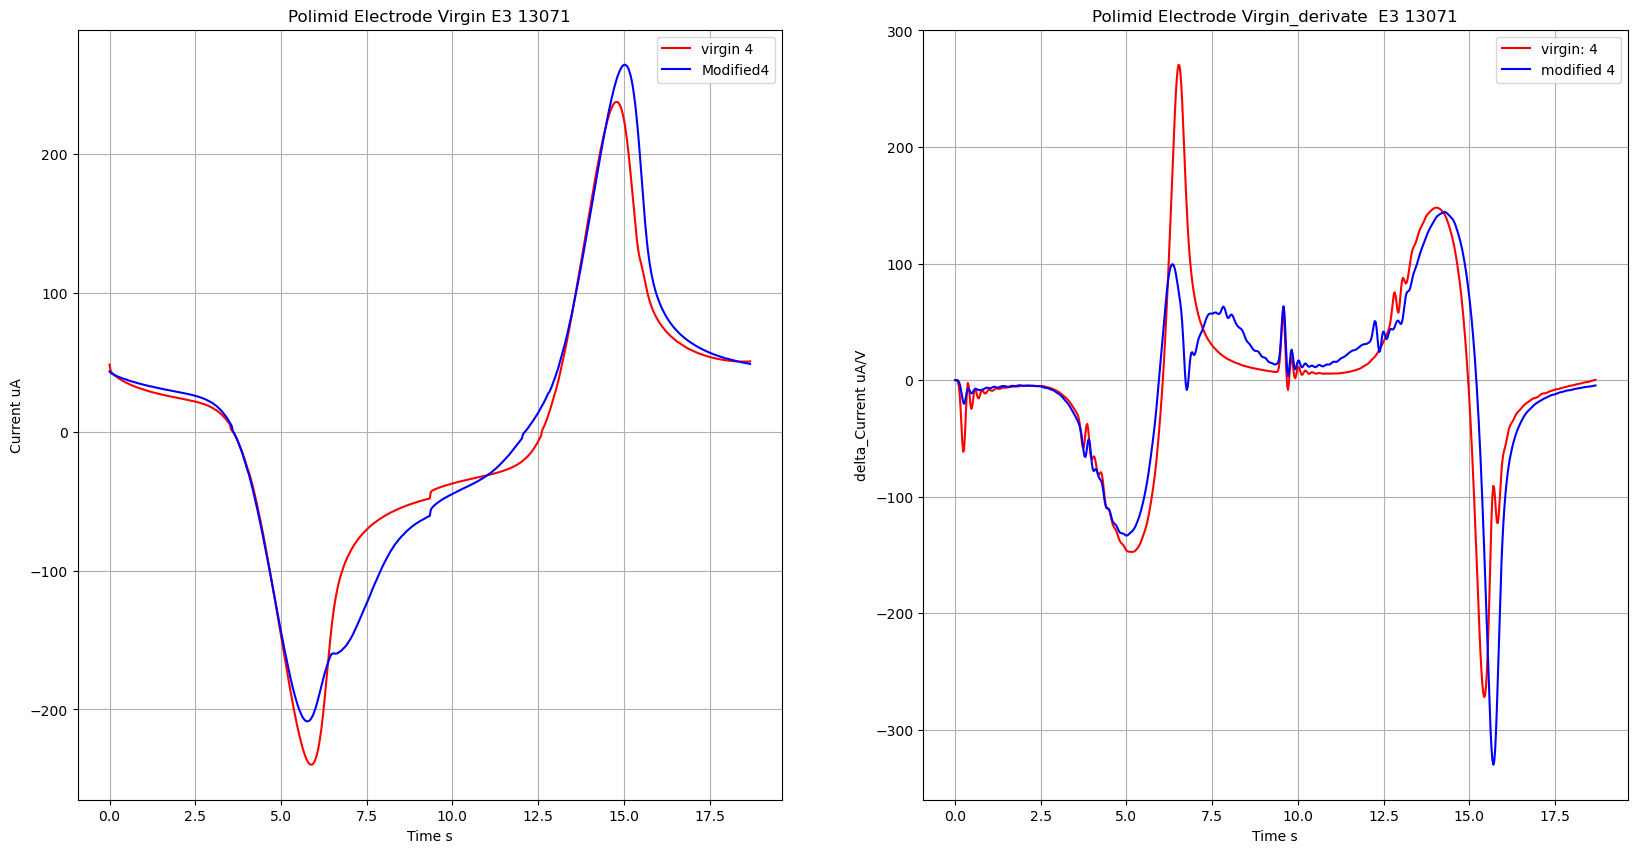

In [33]:
# Dados de eletrodos comerciais sem rodamina
charge_polimid = []
charge_polimid_rod = []
polimid_derivate_virgin_list = []
polimid_derivate_rod_list = []

time = getTime(0.075, potential_poli_elec)

for i in range (1, polimid_df.shape[1]):
    
    current = polimid_df.iloc[:, i].values
    current_rod = polimid_rodamine_df.iloc[:, i].values
    
    d, derivate_virgin = derivate(time, current, True)
    e, derivate_rod  = derivate(time, current_rod, True)
    
    polimid_derivate_virgin_list.append(derivate_virgin)
    polimid_derivate_rod_list.append(derivate_rod)
    
    charge_polimid.append(getTotalCharge(current, time))
    charge_polimid_rod.append(getTotalCharge(current_rod, time))
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax1.set_title("Polimid Electrode Virgin " + polimid_df.columns[i])
    ax1.set_ylabel("Current uA")
    ax1.set_xlabel("Time s")
    ax1.grid(True)
        
    ax2.set_title("Polimid Electrode Virgin_derivate  " + polimid_df.columns[i])
    ax2.set_ylabel("delta_Current uA/V")
    ax2.set_xlabel("Time s")
        
    ax2.grid(True)        
          
    ax1.plot(time, current, color='r', label="virgin " + str(i))
    ax1.plot(time, current_rod, color='b', label="Modified" + str(i))   
    ax1.legend()
    
    ax2.plot(time, derivate_virgin, color='r', label="virgin: " + str(i))
    ax2.plot(time, derivate_rod, color='b', label="modified " + str(i))
    
    
    ax2.legend()
    
plt.show()

## Observando o sinal da primeira derivada dos eletrodos de Polimida em função do tempo 

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


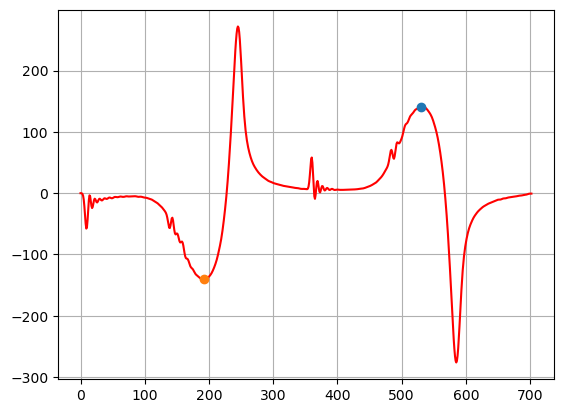

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


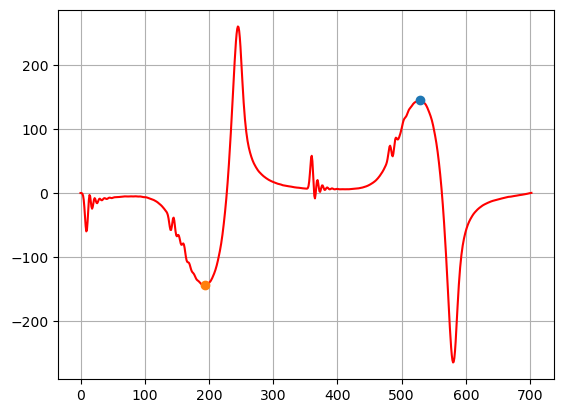

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


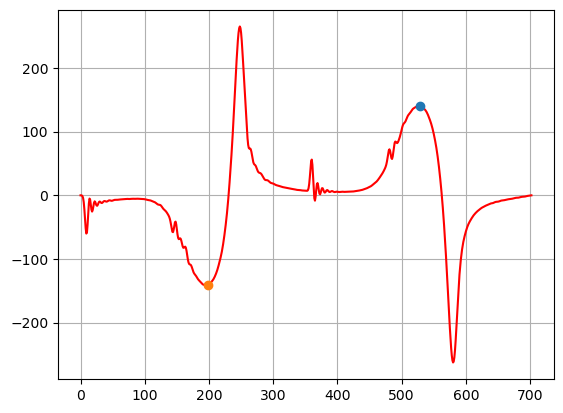

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


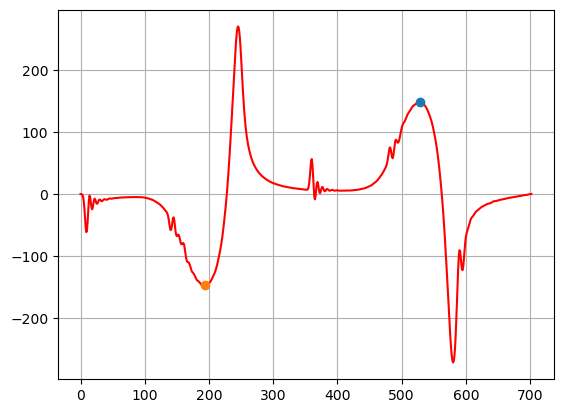

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


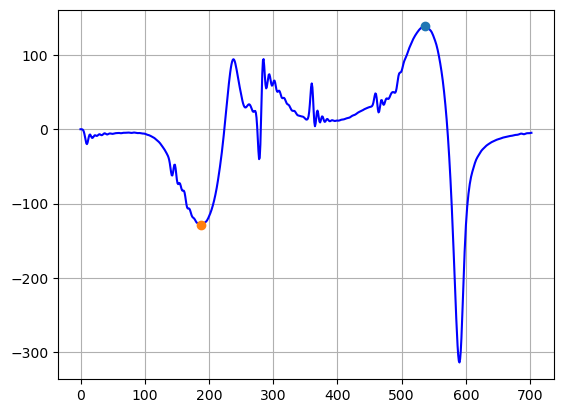

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


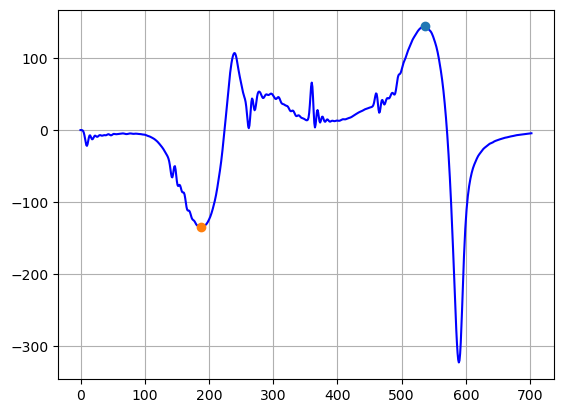

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


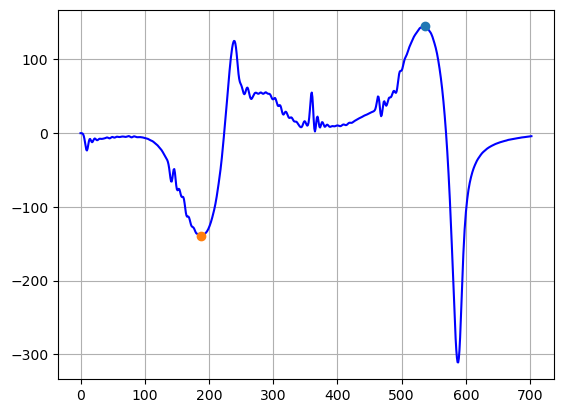

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


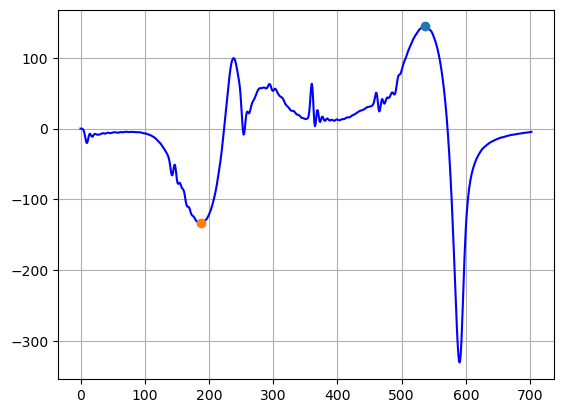

In [34]:
# Eletrodo virgem 
polimid_peak_current_anodic_derivate_virgin = []
polimid_peak_current_cathodic_derivate_virgin = []
polimid_peak_current_anodic_derivate_rodamine = []
polimid_peak_current_cathodic_derivate_rodamine = []

for d in polimid_derivate_virgin_list:
    (anodic, cathodic) = getAnodicAndCathodicArguments(d, fp, ox_inf = 500, ox_sup = 550, red_inf = 150, red_sup = 200)
    polimid_peak_current_anodic_derivate_virgin.append(d[anodic])
    polimid_peak_current_cathodic_derivate_virgin.append(d[cathodic])
    
    plt.plot(d, color='r')
    plt.plot(anodic, d[anodic], marker='o')
    plt.plot(cathodic, d[cathodic], marker='o')
    plt.grid()
    plt.show()
    
# Eletrodo modificado
for d in polimid_derivate_rod_list:
    (anodic, cathodic) = getAnodicAndCathodicArguments(d, fp, ox_inf = 500, ox_sup = 550, red_inf = 150, red_sup = 200)
    polimid_peak_current_anodic_derivate_rodamine.append(d[anodic])
    polimid_peak_current_cathodic_derivate_rodamine.append(d[cathodic])
    plt.plot(d, color='b')
    plt.plot(anodic, d[anodic], marker='o')
    plt.plot(cathodic, d[cathodic], marker='o')
    plt.grid()
    plt.show()

## Estatísticas para o eletrodo de Rodamina
* 1 - Corrente de pico anódica
* 2 - Corrente de pico catódica
* 3 - Diferença entre corrente de pico anódica e catódica
* 4 - Diferença entre potencial anódico e catódico
* 5 - Carga
* 6 - Pico da derivada anódica
* 7 - Pico da derivada catódica

Eletrodo Virgem

Mean: -235.7085
Median: -235.244
Std: 2.673954141342001
Maximum: -232.552
Minumum: -239.794


Eletrodo Modificado

Mean: -209.9085
Median: -210.36849999999998
Std: 6.700778033183904
Maximum: -200.179
Minumum: -218.718


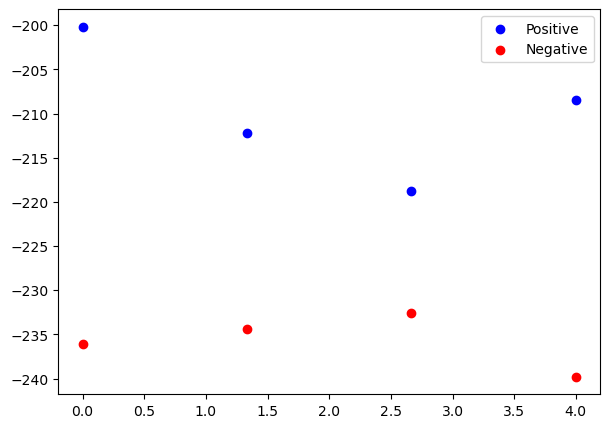

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

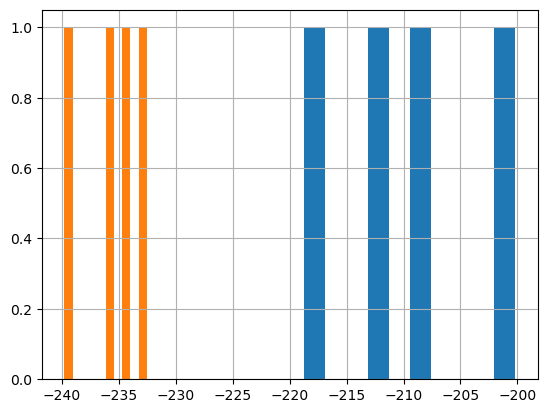

In [35]:
# Corrente Catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(poli_elec_cathodic_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(poli_elec_cathodic_current_rod))
plot_classes(poli_elec_cathodic_current_rod, poli_elec_cathodic_current)
pd.Series(poli_elec_cathodic_current_rod).hist()
pd.Series(poli_elec_cathodic_current).hist()
stats.mannwhitneyu(poli_elec_cathodic_current, poli_elec_cathodic_current_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 233.8225
Median: 234.159
Std: 3.1454021602968387
Maximum: 237.752
Minumum: 229.22


Eletrodo Modificado

Mean: 259.69575
Median: 259.872
Std: 4.115631080101815
Maximum: 264.605
Minumum: 254.434


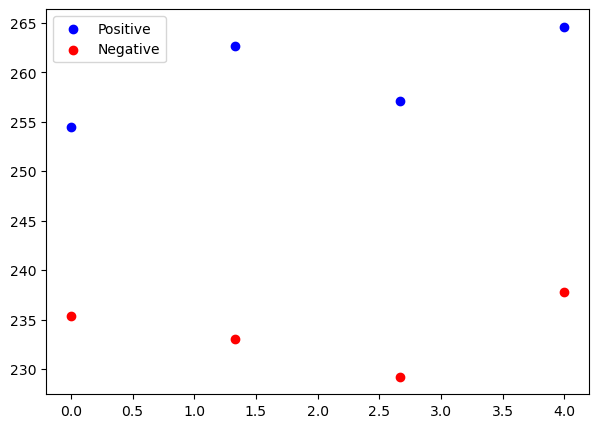

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

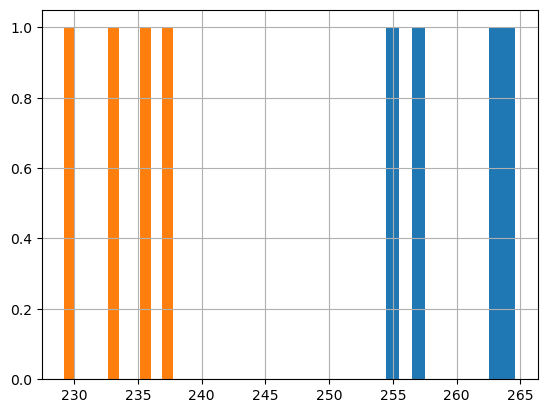

In [36]:
# Corrente Anódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(poli_elec_anodic_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(poli_elec_anodic_current_rod))
plot_classes(poli_elec_anodic_current_rod, poli_elec_anodic_current)
pd.Series(poli_elec_anodic_current_rod).hist()
pd.Series(poli_elec_anodic_current).hist()
stats.mannwhitneyu(poli_elec_anodic_current, poli_elec_anodic_current_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 10.395611072078992
Median: 8.572016876132295
Std: 6.214653151454692
Maximum: 20.574784713172278
Minumum: 3.8636258228791007


Eletrodo Modificado

Mean: 25.61060318831423
Median: 25.567903237757434
Std: 4.141216698584502
Maximum: 31.353169437119163
Minumum: 19.953436840622885


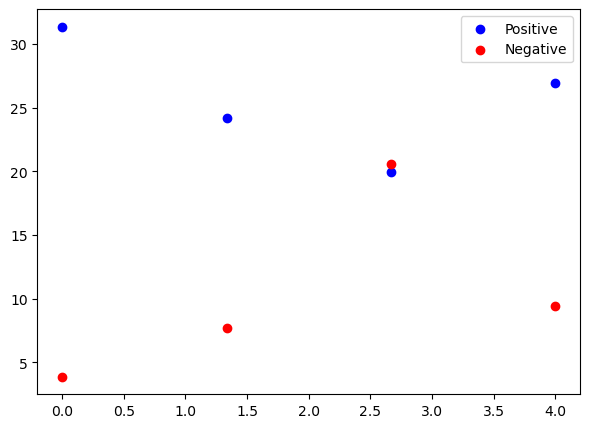

MannwhitneyuResult(statistic=0.0, pvalue=0.05714285714285714)

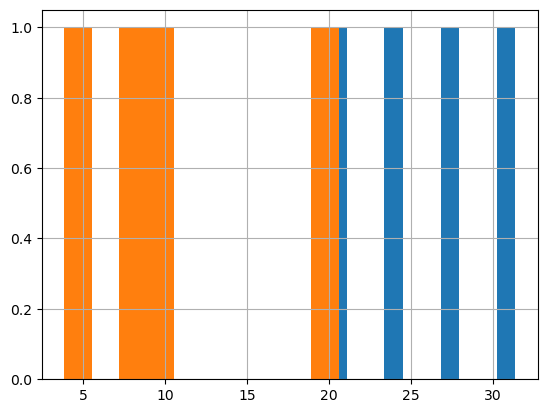

In [71]:
# Carga
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(charge_polimid))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(charge_polimid_rod))
plot_classes(charge_polimid_rod, charge_polimid)
pd.Series(charge_polimid_rod).hist()
pd.Series(charge_polimid).hist()
stats.mannwhitneyu(charge_commertial_rod, charge_polimid, alternative='two-sided')

Eletrodo Virgem

Mean: 469.531
Median: 469.403
Std: 5.761375964125258
Maximum: 477.54600000000005
Minumum: 461.772


Eletrodo Modificado

Mean: 469.60425
Median: 474.017
Std: 8.708128139129553
Maximum: 475.77
Minumum: 454.613


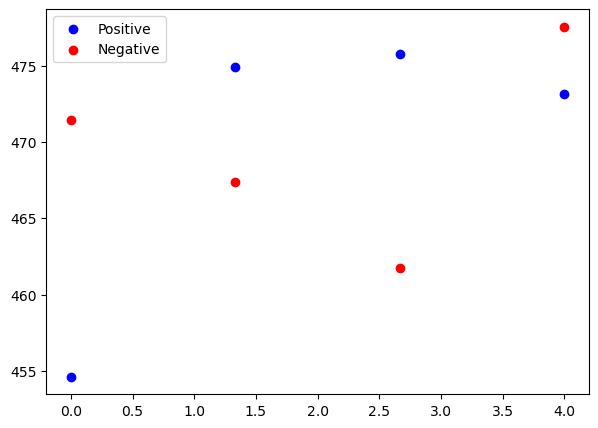

MannwhitneyuResult(statistic=7.0, pvalue=0.8857142857142857)

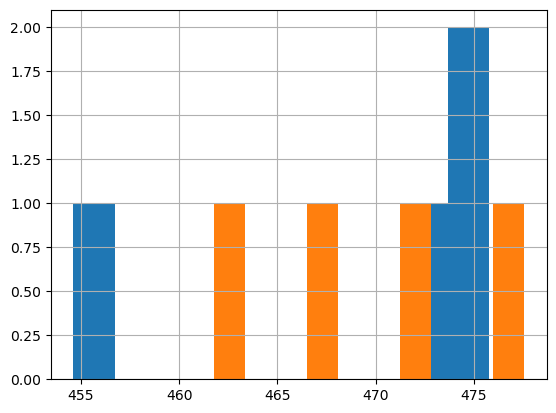

In [37]:
# Diferença entre corrente anódica e catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(poli_elec_diff_ano_cat_current))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(poli_elec_diff_ano_cat_current_rod))
plot_classes(poli_elec_diff_ano_cat_current_rod, poli_elec_diff_ano_cat_current)
pd.Series(poli_elec_diff_ano_cat_current_rod).hist()
pd.Series(poli_elec_diff_ano_cat_current).hist()
stats.mannwhitneyu(poli_elec_diff_ano_cat_current, poli_elec_diff_ano_cat_current_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 0.15422550000000002
Median: 0.15372650000000002
Std: 0.003833998337245338
Maximum: 0.15971600000000002
Minumum: 0.149733


Eletrodo Modificado

Mean: 0.15771949999999998
Median: 0.15871749999999996
Std: 0.00244499902862965
Maximum: 0.15971599999999997
Minumum: 0.153727


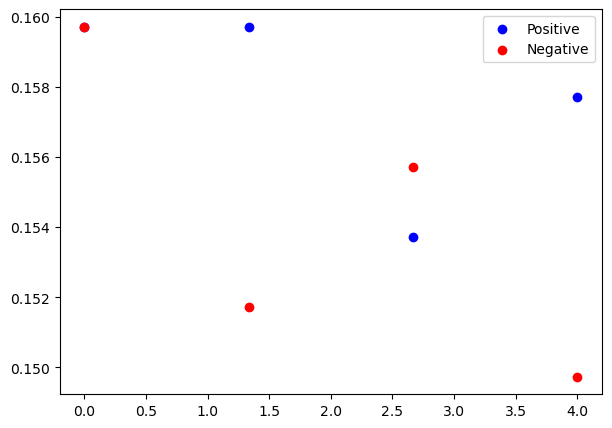

MannwhitneyuResult(statistic=5.0, pvalue=0.46782507728497025)

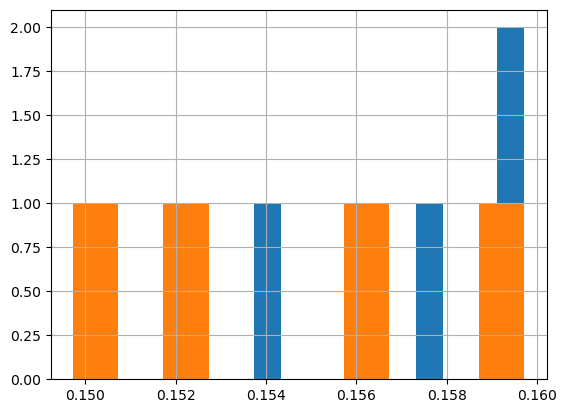

In [39]:
# Diferença entre potencial da currente anódica e catódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(poli_elec_diff_ano_cat_potential))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(poli_elec_diff_ano_cat_potential_rod))
plot_classes(poli_elec_diff_ano_cat_potential_rod, poli_elec_diff_ano_cat_potential)
pd.Series(poli_elec_diff_ano_cat_potential_rod).hist()
pd.Series(poli_elec_diff_ano_cat_potential).hist()
stats.mannwhitneyu(poli_elec_diff_ano_cat_potential, poli_elec_diff_ano_cat_potential_rod, alternative='two-sided')

Eletrodo Virgem

Mean: 143.6428586923905
Median: 142.95399931343871
Std: 2.943971856431541
Maximum: 147.96366222660143
Minumum: 140.69977391608307


Eletrodo Modificado

Mean: 142.76913899172905
Median: 144.00601336003513
Std: 2.576614695596559
Maximum: 144.72726095370322
Minumum: 138.33726829314278


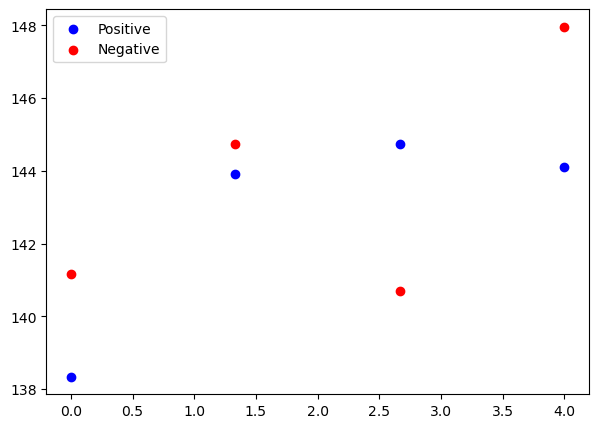

MannwhitneyuResult(statistic=10.0, pvalue=0.6857142857142857)

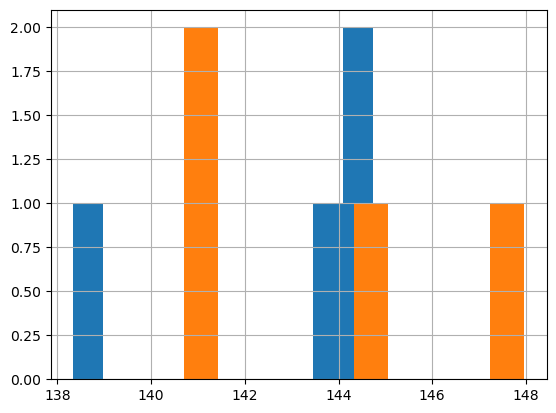

In [40]:
# Pico da corrente da derivada anódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(polimid_peak_current_anodic_derivate_virgin))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(polimid_peak_current_anodic_derivate_rodamine))
plot_classes(polimid_peak_current_anodic_derivate_rodamine, polimid_peak_current_anodic_derivate_virgin)
pd.Series(polimid_peak_current_anodic_derivate_rodamine).hist()
pd.Series(polimid_peak_current_anodic_derivate_virgin).hist()
stats.mannwhitneyu(polimid_peak_current_anodic_derivate_virgin, polimid_peak_current_anodic_derivate_rodamine, alternative='two-sided')

Eletrodo Virgem

Mean: -143.02330520820652
Median: -142.04883888627717
Std: 2.7736597407629984
Maximum: -140.54908131071988
Minumum: -147.44646174955193


Eletrodo Modificado

Mean: -134.0877762274966
Median: -134.2720575022566
Std: 3.8530936711309827
Maximum: -128.5228427197654
Minumum: -139.28414718570775


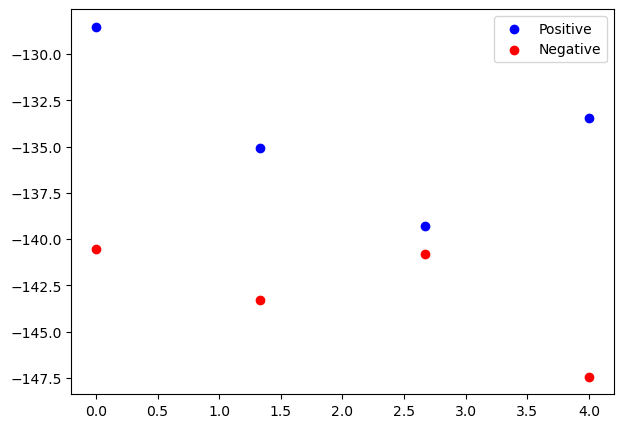

MannwhitneyuResult(statistic=0.0, pvalue=0.02857142857142857)

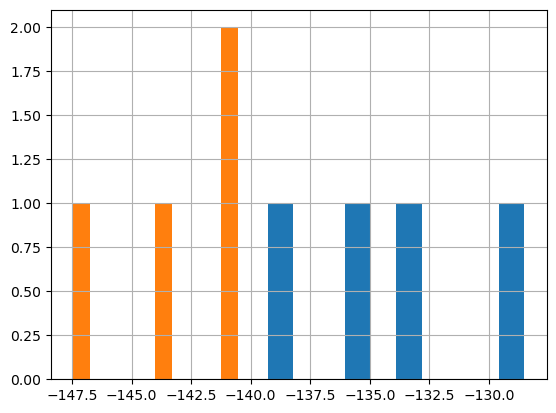

In [41]:
# Pico da corrente da derivada anódica
print("Eletrodo Virgem\n")
elec.showStatistics(np.array(polimid_peak_current_cathodic_derivate_virgin))
print("\n\nEletrodo Modificado\n")
elec.showStatistics(np.array(polimid_peak_current_cathodic_derivate_rodamine))
plot_classes(polimid_peak_current_cathodic_derivate_rodamine, polimid_peak_current_cathodic_derivate_virgin)
pd.Series(polimid_peak_current_cathodic_derivate_rodamine).hist()
pd.Series(polimid_peak_current_cathodic_derivate_virgin).hist()
stats.mannwhitneyu(polimid_peak_current_cathodic_derivate_virgin, polimid_peak_current_cathodic_derivate_rodamine, alternative='two-sided')

## Montando o dataset para o eletrodo comercial

In [42]:
columns = ['corrente_anodica', 'corrente_catodica', 'carga','diff_corrente_anodica_catodica', 'diff_pot_anodico_catodico', 'pico_derivada_anodica', 'pico_derivada_catodica', 'target']
com_virgin_df = pd.DataFrame(columns=columns)
com_rod_df = pd.DataFrame(columns=columns)
com_virgin_df['corrente_anodica'] = np.array(comertial_elec_anodic_current)
com_virgin_df['corrente_catodica'] = np.array(comertial_elec_cathodic_current)
com_virgin_df['carga'] = np.array(charge_commertial)
com_virgin_df['diff_corrente_anodica_catodica'] = np.array(comertial_elec_diff_ano_cat_current)
com_virgin_df['diff_pot_anodico_catodico'] = np.array(comertial_elec_diff_ano_cat_potential)
com_virgin_df['pico_derivada_anodica'] = np.array(comertial_peak_current_anodic_derivate_virgin)
com_virgin_df['pico_derivada_catodica'] = np.array(comertial_peak_current_cathodic_derivate_virgin)
#com_virgin_df['target'] = np.ones(shape=(len(charge_pos), 1), dtype=np.int8)

com_rod_df['corrente_anodica'] = np.array(comertial_elec_anodic_current_rod)
com_rod_df['corrente_catodica'] = np.array(comertial_elec_cathodic_current_rod)
com_rod_df['carga'] = np.array(charge_commertial_rod)
com_rod_df['diff_corrente_anodica_catodica'] = np.array(comertial_elec_diff_ano_cat_current_rod)
com_rod_df['diff_pot_anodico_catodico'] = np.array(comertial_elec_diff_ano_cat_potential_rod)
com_rod_df['pico_derivada_anodica'] = np.array(comertial_peak_current_anodic_derivate_rodamine)
com_rod_df['pico_derivada_catodica'] = np.array(comertial_peak_current_cathodic_derivate_rodamine)
#com_rod_df['target'] = np.zeros(shape=(len(charge_neg), 1), dtype=np.int8)

com_virgin_df.to_csv("comertial_virgin.csv")
com_virgin_df.to_csv("comertial_rodamine.csv")

In [43]:
columns = ['corrente_anodica', 'corrente_catodica', 'carga','diff_corrente_anodica_catodica', 'diff_pot_anodico_catodico', 'pico_derivada_anodica', 'pico_derivada_catodica', 'target']
poli_virgin_df = pd.DataFrame(columns=columns)
poli_rod_df = pd.DataFrame(columns=columns)
poli_virgin_df['corrente_anodica'] = np.array(poli_elec_anodic_current)
poli_virgin_df['corrente_catodica'] = np.array(poli_elec_cathodic_current)
poli_virgin_df['carga'] = np.array(charge_polimid)
poli_virgin_df['diff_corrente_anodica_catodica'] = np.array(poli_elec_diff_ano_cat_current)
poli_virgin_df['diff_pot_anodico_catodico'] = np.array(poli_elec_diff_ano_cat_potential)
poli_virgin_df['pico_derivada_anodica'] = np.array(polimid_peak_current_anodic_derivate_virgin)
poli_virgin_df['pico_derivada_catodica'] = np.array(polimid_peak_current_cathodic_derivate_virgin)
#com_virgin_df['target'] = np.ones(shape=(len(charge_pos), 1), dtype=np.int8)

poli_rod_df['corrente_anodica'] = np.array(poli_elec_anodic_current_rod)
poli_rod_df['corrente_catodica'] = np.array(poli_elec_cathodic_current_rod)
poli_rod_df['carga'] = np.array(charge_polimid_rod)
poli_rod_df['diff_corrente_anodica_catodica'] = np.array(poli_elec_diff_ano_cat_current_rod)
poli_rod_df['diff_pot_anodico_catodico'] = np.array(poli_elec_diff_ano_cat_potential_rod)
poli_rod_df['pico_derivada_anodica'] = np.array(polimid_peak_current_anodic_derivate_rodamine)
poli_rod_df['pico_derivada_catodica'] = np.array(polimid_peak_current_cathodic_derivate_rodamine)
#com_rod_df['target'] = np.zeros(shape=(len(charge_neg), 1), dtype=np.int8)

poli_virgin_df.to_csv("polimid_virgin.csv")
poli_virgin_df.to_csv("polimid_rodamine.csv")